<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab10-convolutional-neural-network-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10 - Convolutional Neural Network, CNN

### Author: Szymon Nowakowski

# Presentation on Convolutional Layers
--------------------

We shall start off by going through a [short presentation on convolusional layers](https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/convolutional_layers.pdf). It is best to first download it and then go through it in a slide-show layout.

# Reading MNIST Dataset
----------------------------------

In [169]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

# Tensor Sizes
-------------------

Recall:
- Batched labels are of order one. The first (and only) index is a sample index within a batch.
- Image batches have order 4. The first order is a batch order, but a second order has dimensionality of 1 and thus it can be indexed by 0 only.
  - This index represents a Channel number inserted here by `ToTensor()` transformation, always 0.
  - This singleton order should be retained because we want to use convolutional layers, which explicitly require this order. For RGB images we have 3 channels, for B&W images we have only one channel.


# CNN Definition
-----------------



## Task

Your job now is to code the definition of the LeNet5 neural network. You can find the definition [here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg).


In [170]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(kernel_size = 5, in_channels = 1, out_channels = 6)
        self.conv2 = torch.nn.Conv2d(kernel_size = 5, in_channels = 6, out_channels = 16)
        self.conv3 = torch.nn.Conv2d(kernel_size = 4, in_channels = 16, out_channels = 120)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(120, 84)
        self.linear2 = torch.nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x): # B, 1, 28, 28
        x = self.relu(self.conv1(x)) # B, 6, 24, 24
        x = self.pool(x) # B, 6, 12, 12
        x = self.relu(self.conv2(x)) # B, 16, 8, 8
        x = self.pool(x)  # B, 16, 4, 4
        x = self.relu(self.conv3(x)) # B, 120, 1, 1
        x = x.squeeze(-1).squeeze(-1) #B, 120
        x = F.relu(self.linear1(x)) #B, 84
        x = self.linear2(x) #B, 84
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [171]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3013176918029785
epoch: 0 batch: 1 current batch loss: 2.2949447631835938
epoch: 0 batch: 2 current batch loss: 2.2857391834259033
epoch: 0 batch: 3 current batch loss: 2.27423357963562
epoch: 0 batch: 4 current batch loss: 2.263230323791504
epoch: 0 batch: 5 current batch loss: 2.2518043518066406
epoch: 0 batch: 6 current batch loss: 2.229663610458374
epoch: 0 batch: 7 current batch loss: 2.205263137817383
epoch: 0 batch: 8 current batch loss: 2.1766674518585205
epoch: 0 batch: 9 current batch loss: 2.1477224826812744
epoch: 0 batch: 10 current batch loss: 2.103654146194458
epoch: 0 batch: 11 current batch loss: 2.0475966930389404
epoch: 0 batch: 12 current batch loss: 2.0095858573913574
epoch: 0 batch: 13 current batch loss: 1.9467973709106445
epoch: 0 batch: 14 current batch loss: 1.8790277242660522
epoch: 0 batch: 15 current batch loss: 1.787292242050171
epoch: 0 batch: 16 current batch loss: 1.7084773778915405
epoch: 0 batch:

# Testing
----------------------

In [172]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9781


# Understanding Kernel Size, Stride and Padding

## Task: Designing a Convolutional Neural Network with a Target Receptive Field

Design a convolutional neural network using only 3×3 or 5×5 convolutional layers and 2×2 max-pooling layers without overlap (i.e., with stride 2). Use no padding in any layer. Insert a max-pooling layer after every two or three convolutional layers.

Your goal is to construct an architecture such that the receptive field of each output neuron is approximately 60×60 pixels.

Compute the receptive field size of the final output layer.

Compute the effective stride of the output layer with respect to the input.

Assuming an input image size of 400×400, determine the spatial size of the output feature map.

Q: Where would you locate ReLU layers?
Q: What if we can't match the desired input size with our architecture?
Q: Discuss what possible impact padding can have on the network performance.



# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

# Solution 

# Task 1

Let's solve task 1. We are going to use the same function as in homework 9. We are going to do exactly the same thing but with different model.

In [173]:
def plot_numbers(points):   #function for plotting trained points
    
    fig, axes = pyplot.subplots(1, 10, figsize=(15, 3))

    for i, ax in enumerate(axes):
        img = points[i].squeeze().detach().cpu().numpy()
        ax.imshow(img)      
        ax.set_title(f"{i}")            
        ax.axis('off')             

    pyplot.tight_layout()
    pyplot.show()



def train_input(net, lambda_l2 = 0, lr = 0.001, prob = 0.99999, plot = False, info = 2000, max_iter = 40000):   # main function
    
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
    
    points = torch.randn(10, 1, 28, 28).to(device)
    points.requires_grad = True
    true = torch.LongTensor(range(0,10)).to(device)   # defining random noise and output
    
    optimizer = torch.optim.Adam([points], lr)

    epoch = 0
    
    while ( not all([torch.max(torch.nn.functional.softmax(net(points[number]).reshape(1, 10), dim = 1)) > prob for number in range(0,10)]) ) and (epoch < max_iter):
    
        optimizer.zero_grad()
        preds = net(points)   
        loss = torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()
    
        epoch += 1
        if epoch % info == 0:
            with torch.no_grad():
                print("Iteration", epoch, "current batch loss:", loss.item())
                print("Predicted value: ", [torch.argmax(torch.nn.functional.softmax(net(points[number]).reshape(1, 10), dim = 1)).item() for number in range(0,10)], "\n", 
                  "Predicted probability: ", [round(torch.max(torch.nn.functional.softmax(net(points[number]).reshape(1, 10), dim = 1)).item(), 6) for number in range(0,10)])
                if plot:
                    plot_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())
    
    for parameters in net.parameters():
        parameters.requires_grad = True  # unfreezing model
        
    return points

# $\lambda = 0$

Iteration 2000 current batch loss: 0.012059171684086323
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99123, 0.96595, 0.995115, 0.991729, 0.988871, 0.992814, 0.984947, 0.984693, 0.998744, 0.986407]


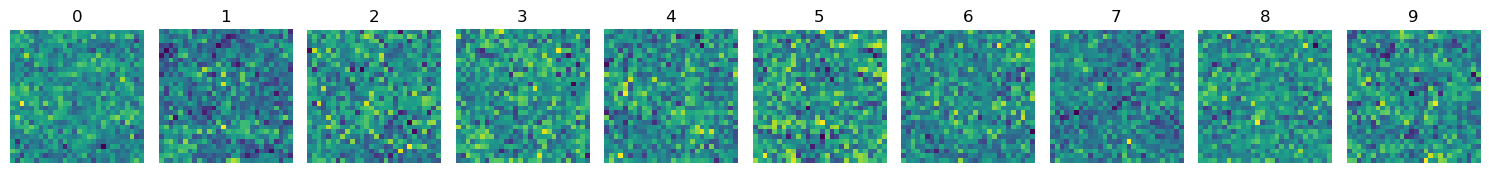

Iteration 4000 current batch loss: 0.0029401681385934353
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997771, 0.991315, 0.998827, 0.998158, 0.997501, 0.998333, 0.996216, 0.996366, 0.99967, 0.996509]


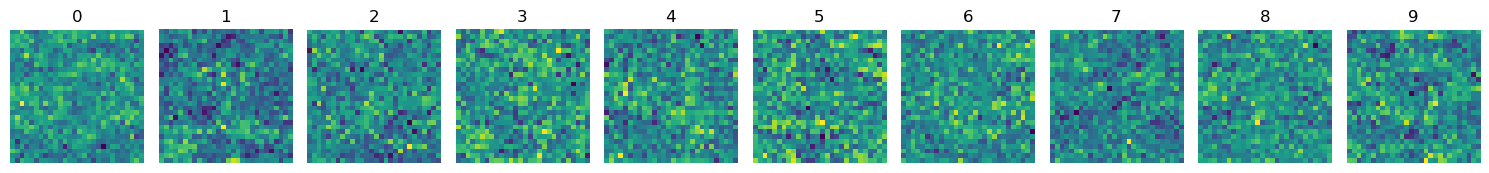

Iteration 6000 current batch loss: 0.0009960781317204237
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999229, 0.997005, 0.99962, 0.999398, 0.999155, 0.999432, 0.998653, 0.998805, 0.999894, 0.998857]


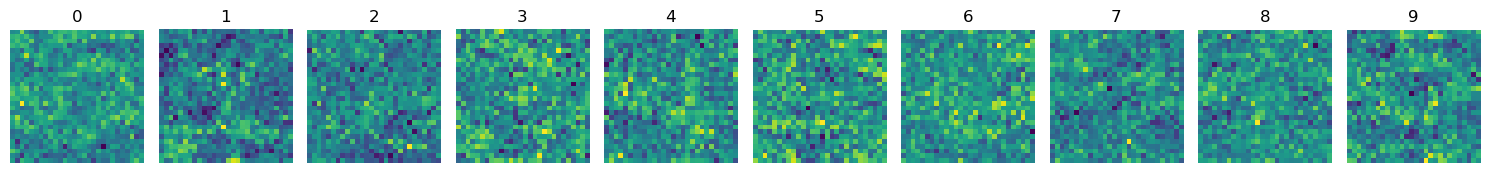

Iteration 8000 current batch loss: 0.0003576785675249994
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999721, 0.998887, 0.999874, 0.99979, 0.999694, 0.999795, 0.999505, 0.999571, 0.999963, 0.999626]


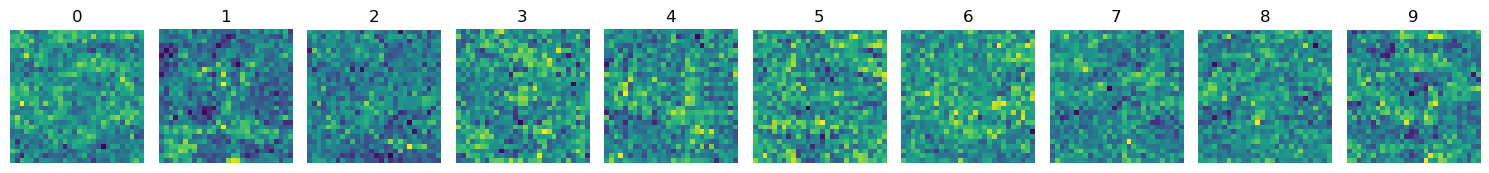

Iteration 10000 current batch loss: 0.00012831583444494754
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999897, 0.999621, 0.999955, 0.999924, 0.999891, 0.999924, 0.999818, 0.999829, 0.999987, 0.999871]


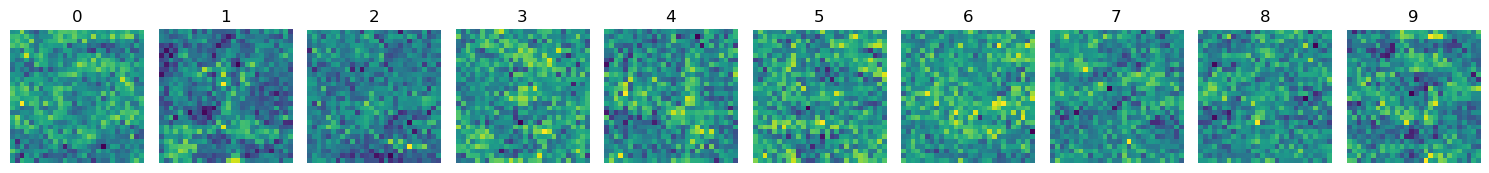

Iteration 12000 current batch loss: 4.7443525545531884e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99996, 0.999859, 0.999984, 0.999972, 0.999959, 0.999971, 0.999938, 0.999933, 0.999995, 0.999953]


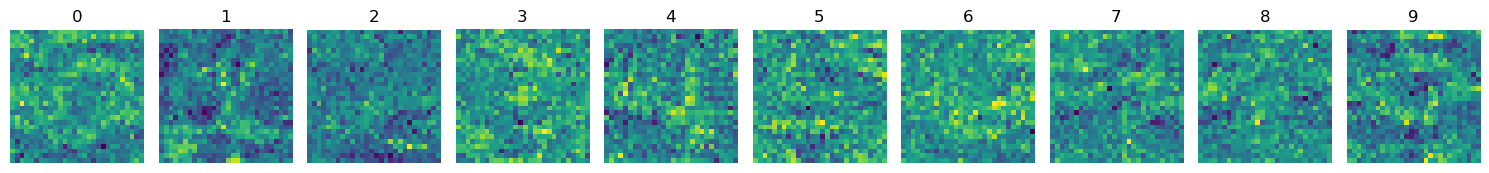

Iteration 14000 current batch loss: 1.7249351003556512e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999985, 0.999949, 0.999994, 0.99999, 0.999984, 0.999989, 0.99998, 0.999975, 0.999998, 0.999983]


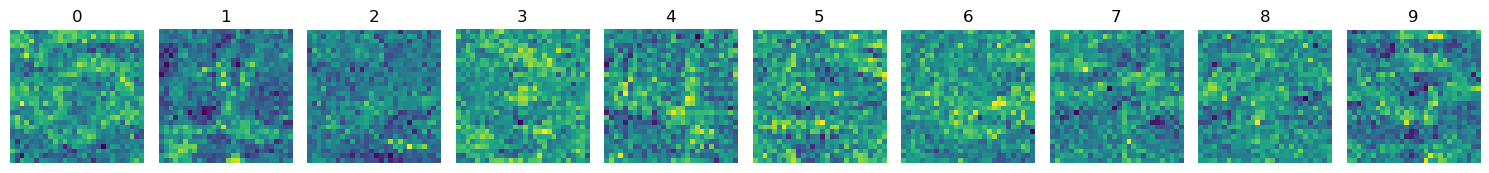

Iteration 16000 current batch loss: 6.3419029174838215e-06
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999994, 0.999982, 0.999998, 0.999996, 0.999994, 0.999996, 0.999993, 0.999991, 0.999999, 0.999994]


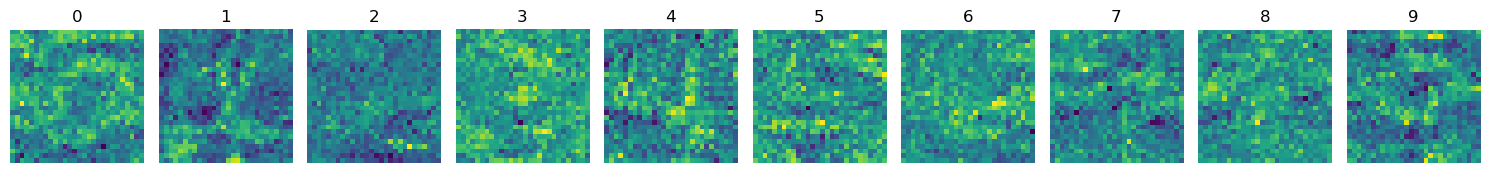

Iteration 17273 current batch loss: 3.3855351375677856e-06


In [174]:
points_1 = train_input(net, plot = True)

# $\lambda = 0.01$

Iteration 2000 current batch loss: 0.023680545389652252
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.990849, 0.944155, 0.996787, 0.997893, 0.991366, 0.995044, 0.990143, 0.986397, 0.999029, 0.97629]


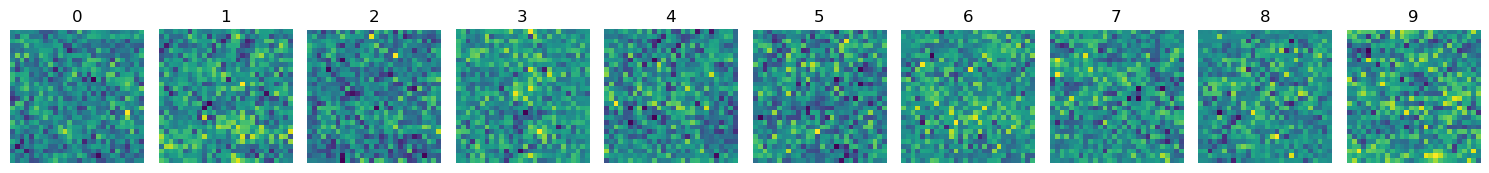

Iteration 4000 current batch loss: 0.012537555769085884
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997183, 0.98863, 0.999122, 0.999368, 0.997656, 0.998593, 0.997346, 0.996351, 0.999566, 0.993959]


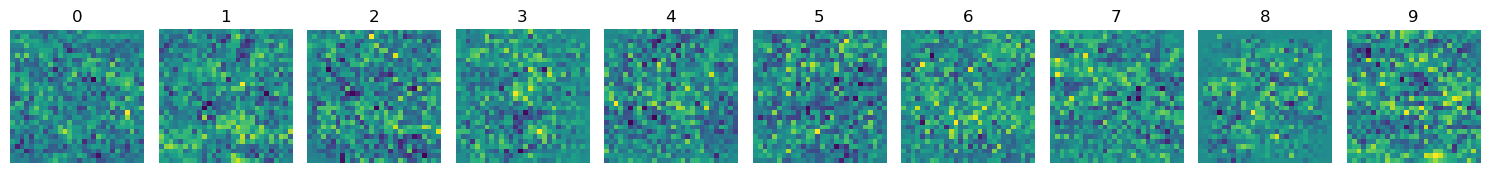

Iteration 6000 current batch loss: 0.008986527100205421
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998764, 0.995906, 0.999604, 0.999578, 0.998974, 0.99939, 0.999147, 0.998415, 0.999695, 0.99768]


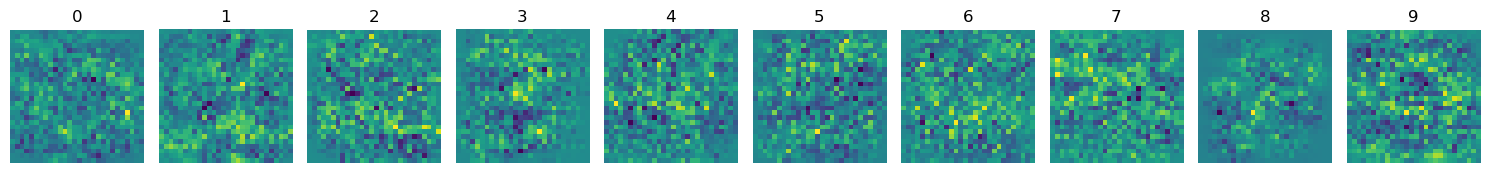

Iteration 8000 current batch loss: 0.006454444490373135
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999277, 0.998212, 0.999728, 0.999663, 0.999411, 0.99961, 0.999544, 0.999108, 0.999744, 0.998816]


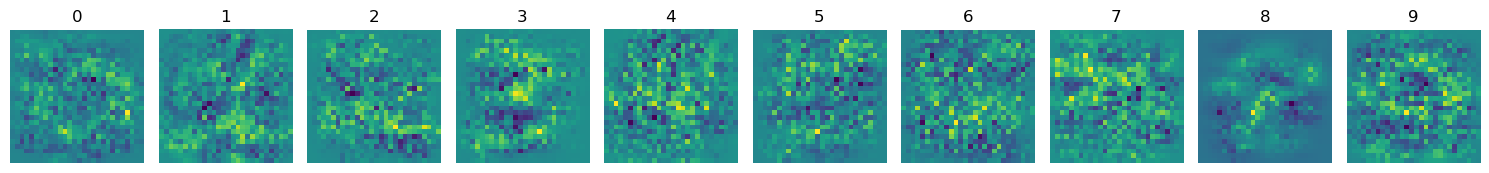

Iteration 10000 current batch loss: 0.004345429129898548
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99941, 0.99889, 0.999754, 0.999695, 0.99957, 0.999774, 0.999633, 0.999331, 0.999755, 0.999221]


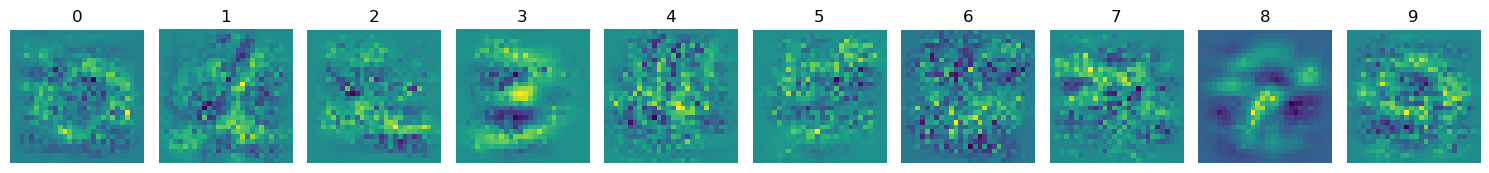

Iteration 12000 current batch loss: 0.0028066840022802353
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999466, 0.99912, 0.99977, 0.999712, 0.999642, 0.999813, 0.999651, 0.999516, 0.999756, 0.999445]


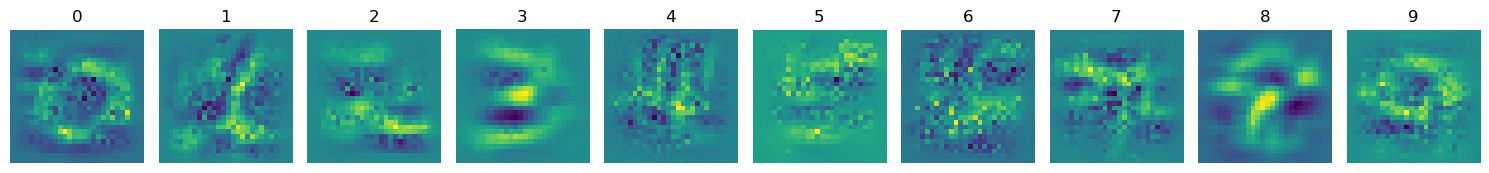

Iteration 14000 current batch loss: 0.002049606991931796
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999511, 0.999206, 0.999776, 0.999715, 0.999697, 0.99983, 0.999658, 0.999601, 0.999756, 0.999565]


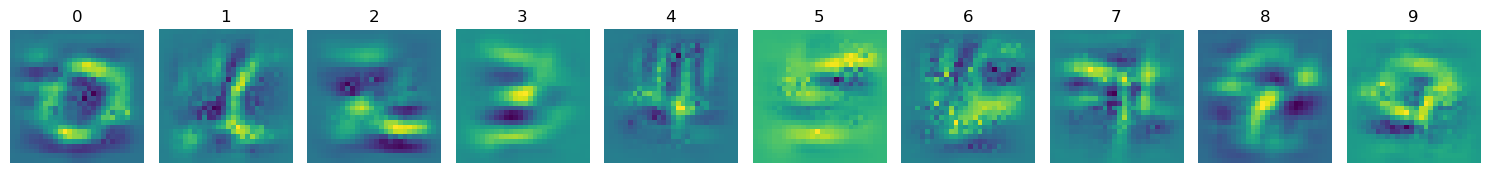

Iteration 16000 current batch loss: 0.0018150070682168007
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999518, 0.999451, 0.999783, 0.999716, 0.999713, 0.999837, 0.999662, 0.999639, 0.999757, 0.999579]


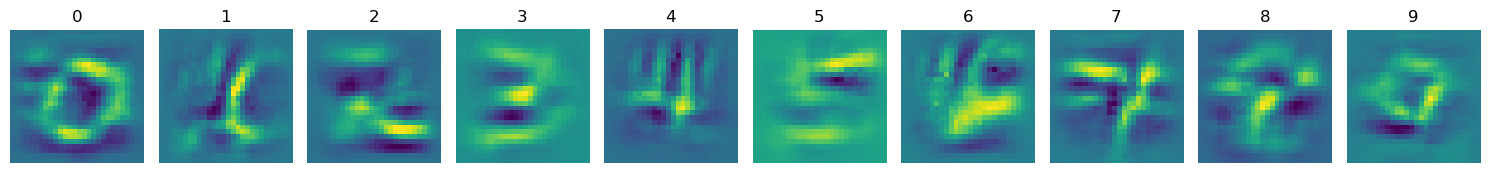

Iteration 18000 current batch loss: 0.0017169011989608407
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999512, 0.999783, 0.999716, 0.999723, 0.999838, 0.999662, 0.999656, 0.999757, 0.99958]


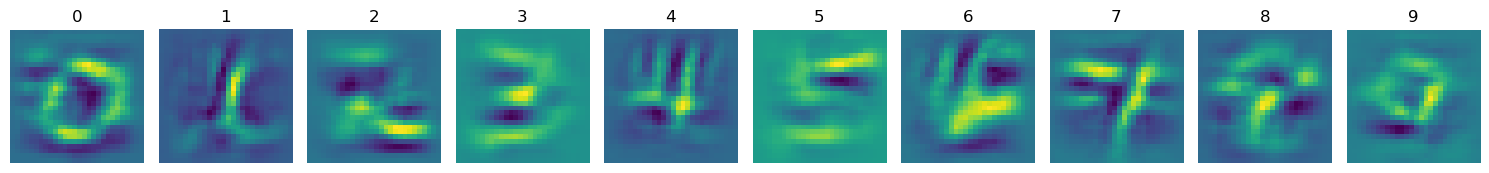

Iteration 20000 current batch loss: 0.00170917680952698
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999758, 0.99958]


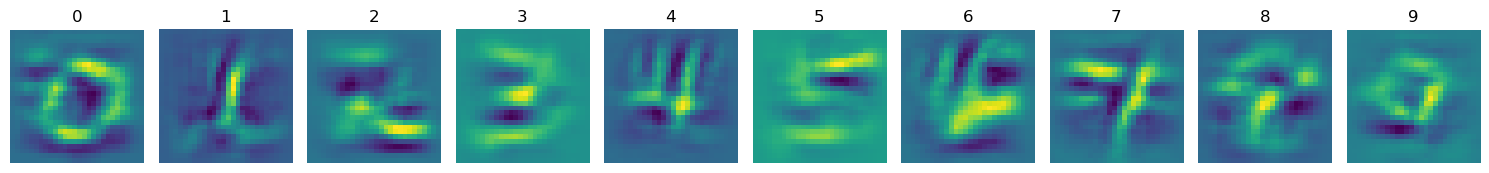

Iteration 22000 current batch loss: 0.0017091534100472927
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


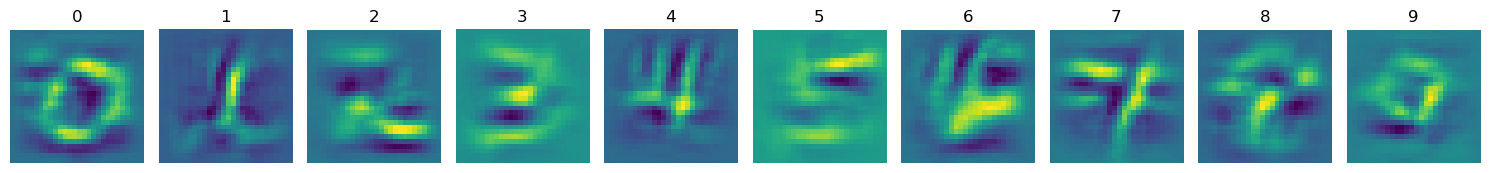

Iteration 24000 current batch loss: 0.0017091846093535423
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


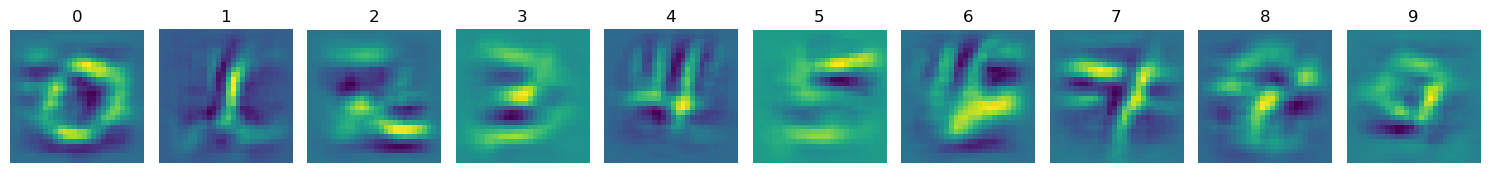

Iteration 26000 current batch loss: 0.0017092011403292418
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999658, 0.999757, 0.99958]


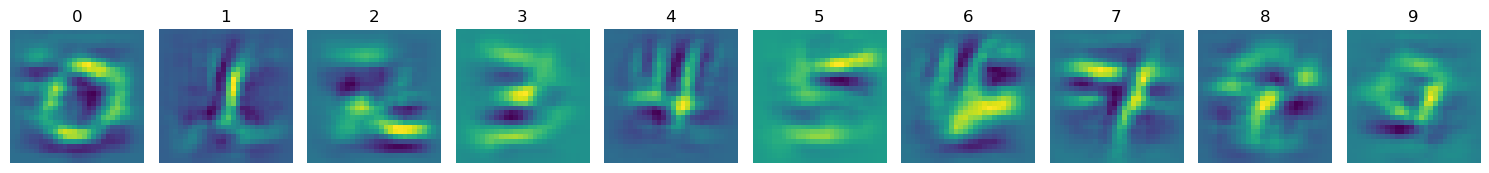

Iteration 28000 current batch loss: 0.0017091840272769332
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99952, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


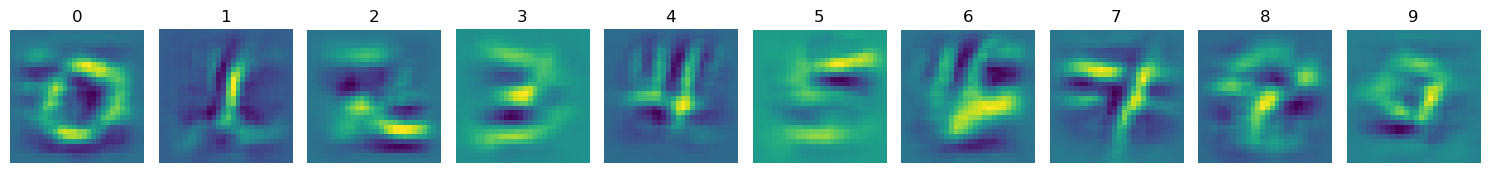

Iteration 30000 current batch loss: 0.0017091489862650633
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


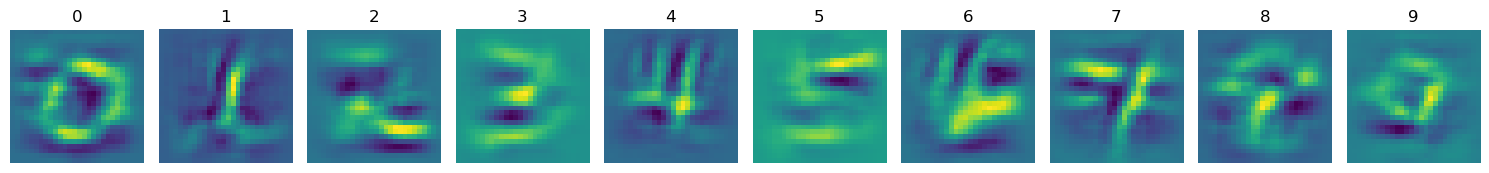

Iteration 32000 current batch loss: 0.0017091796034947038
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


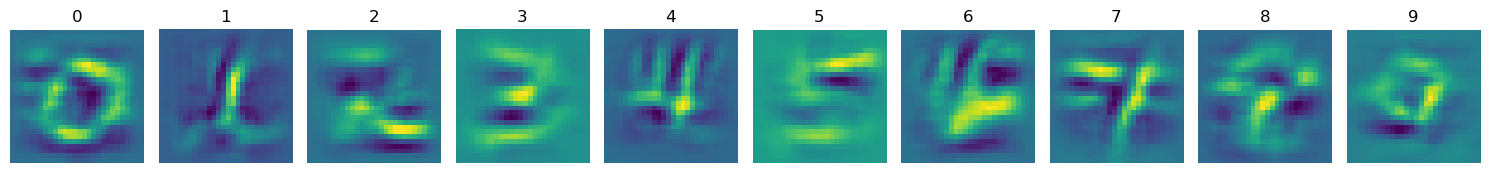

Iteration 34000 current batch loss: 0.0017091715708374977
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


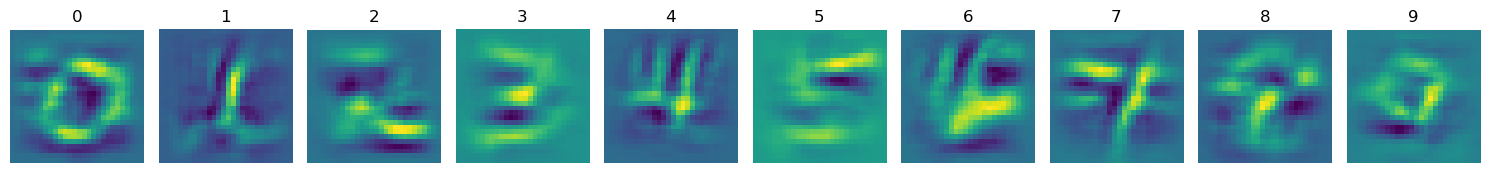

Iteration 36000 current batch loss: 0.0017092223279178143
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999715, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


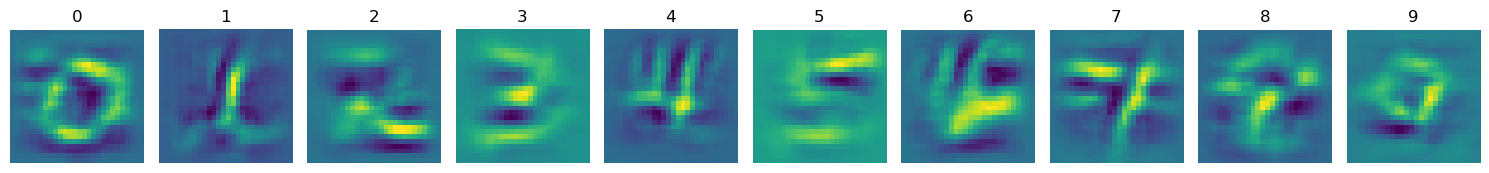

Iteration 38000 current batch loss: 0.0017092307098209858
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


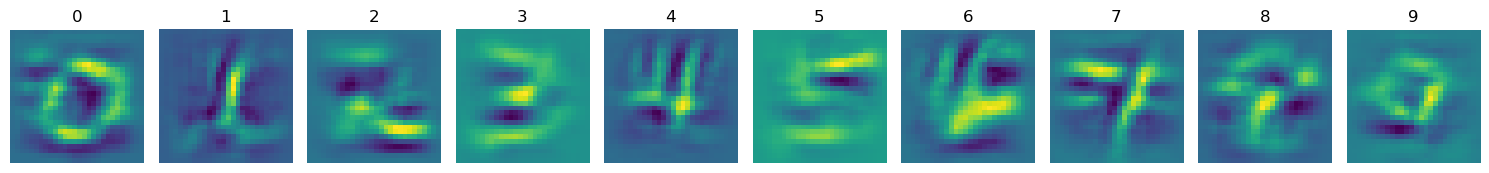

Iteration 40000 current batch loss: 0.001709179487079382
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999519, 0.999521, 0.999783, 0.999716, 0.999724, 0.999838, 0.999662, 0.999657, 0.999757, 0.99958]


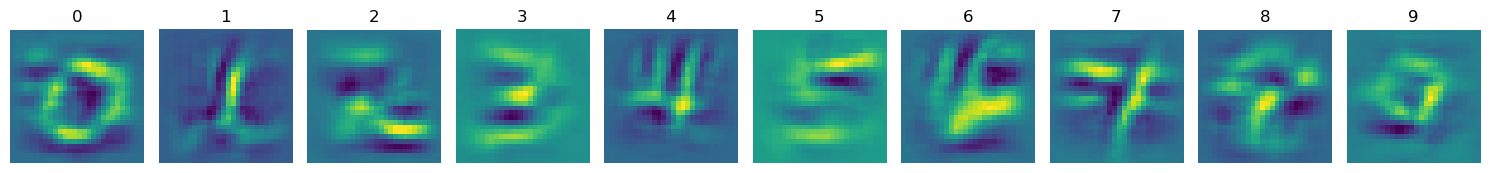

Iteration 40000 current batch loss: 0.001709179487079382


In [175]:
points_2 = train_input(net, lambda_l2 = 0.01, plot = True)

# $\lambda = 0.1$

Iteration 2000 current batch loss: 0.09624537825584412
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.987216, 0.953096, 0.992112, 0.990243, 0.985366, 0.993812, 0.984994, 0.987699, 0.997539, 0.984595]


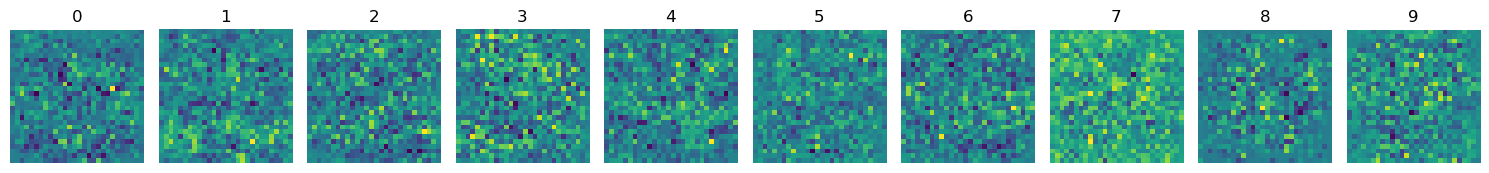

Iteration 4000 current batch loss: 0.05916345864534378
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99409, 0.985067, 0.996631, 0.996018, 0.995054, 0.997708, 0.994594, 0.994463, 0.998166, 0.993908]


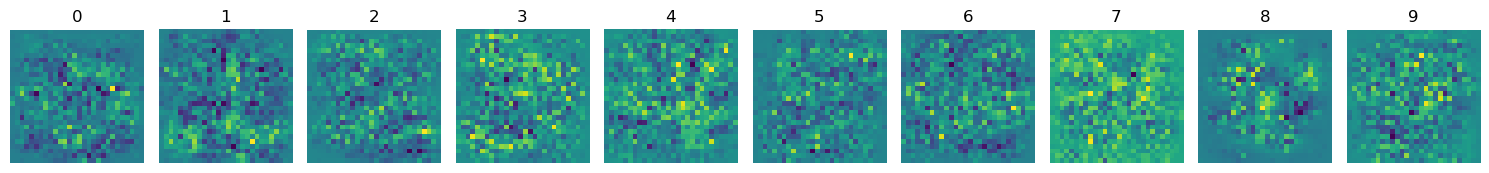

Iteration 6000 current batch loss: 0.03357601910829544
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99561, 0.993851, 0.997438, 0.99706, 0.996299, 0.998101, 0.996934, 0.996343, 0.998313, 0.99588]


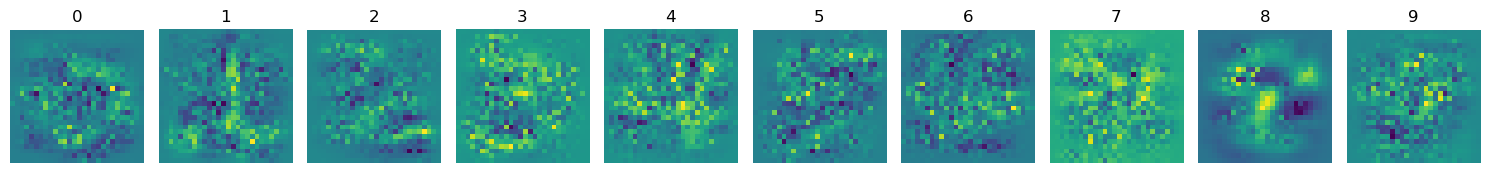

Iteration 8000 current batch loss: 0.017984803766012192
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996234, 0.996057, 0.997937, 0.997259, 0.997004, 0.998446, 0.997285, 0.996899, 0.998325, 0.996651]


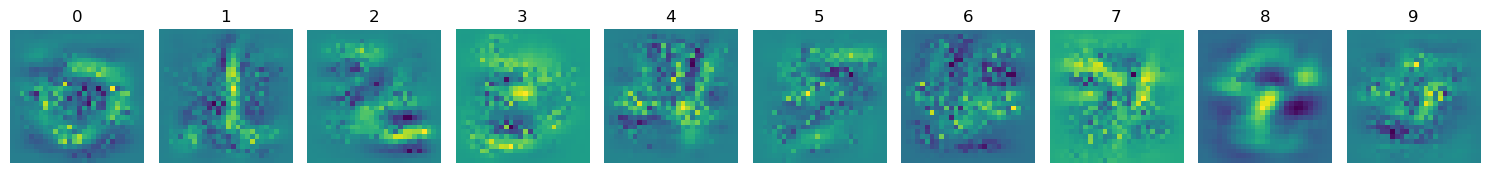

Iteration 10000 current batch loss: 0.011997820809483528
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996475, 0.996249, 0.998297, 0.997444, 0.997309, 0.998613, 0.997437, 0.997367, 0.998322, 0.996904]


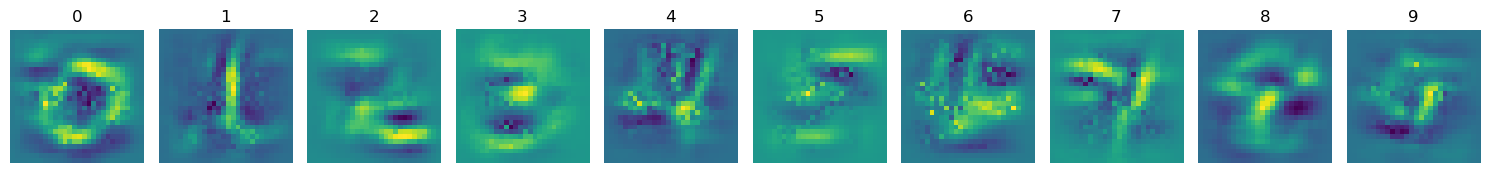

Iteration 12000 current batch loss: 0.010819820687174797
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996518, 0.996408, 0.998337, 0.997613, 0.997686, 0.998676, 0.997458, 0.99754, 0.998322, 0.997]


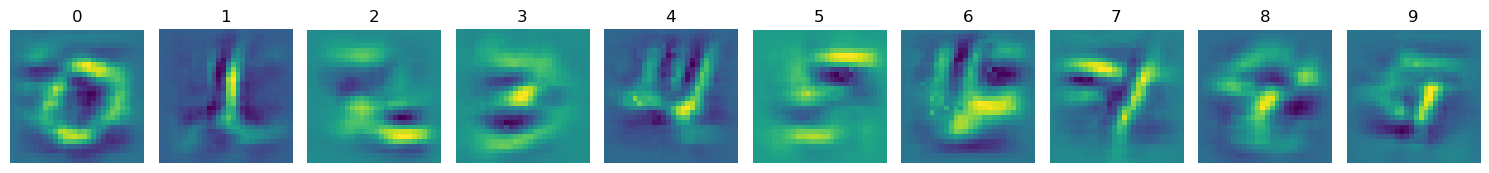

Iteration 14000 current batch loss: 0.010612653568387032
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99653, 0.99646, 0.99834, 0.997807, 0.997862, 0.998682, 0.997457, 0.997561, 0.998322, 0.996991]


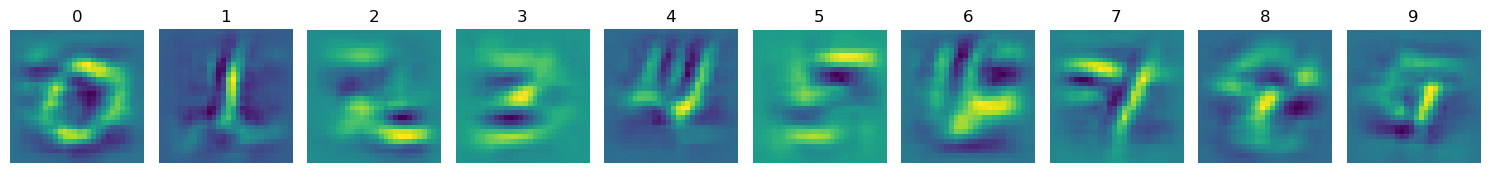

Iteration 16000 current batch loss: 0.010611563920974731
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996532, 0.996463, 0.998342, 0.99781, 0.997859, 0.998683, 0.997457, 0.997562, 0.998322, 0.996992]


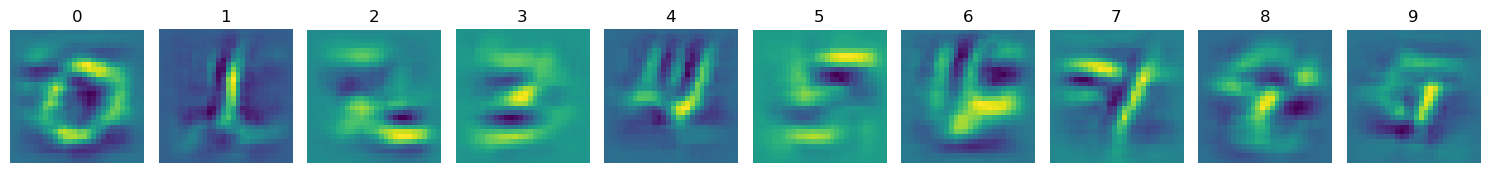

Iteration 18000 current batch loss: 0.010611817240715027
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996532, 0.99646, 0.998338, 0.99781, 0.99786, 0.998682, 0.997456, 0.997562, 0.99832, 0.996992]


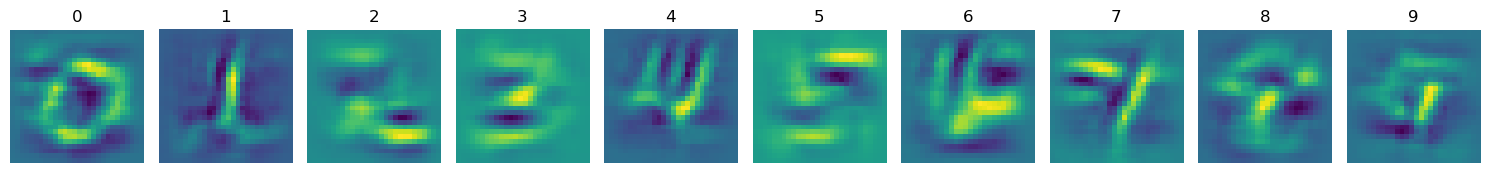

Iteration 20000 current batch loss: 0.010611909441649914
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99653, 0.996461, 0.998334, 0.99781, 0.99786, 0.998681, 0.997457, 0.99756, 0.99832, 0.996992]


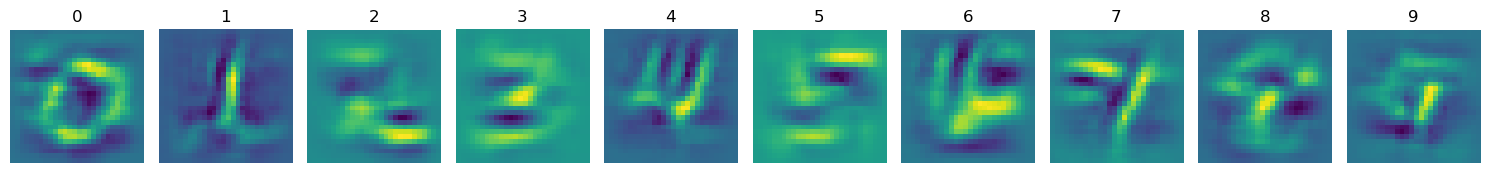

Iteration 22000 current batch loss: 0.010611822828650475
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996531, 0.99646, 0.998339, 0.997808, 0.99786, 0.998683, 0.997456, 0.997563, 0.998323, 0.996992]


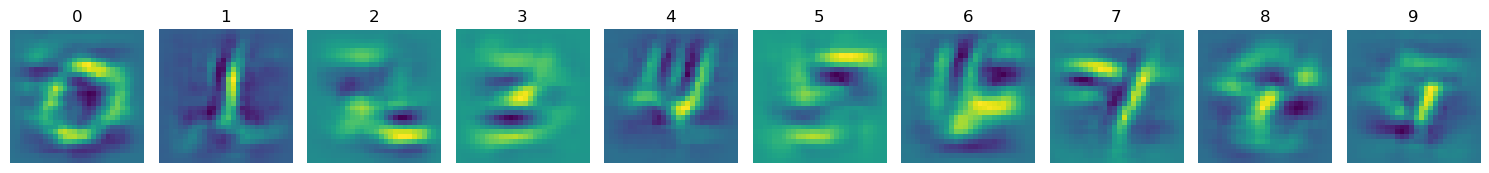

Iteration 24000 current batch loss: 0.01061168871819973
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99653, 0.996462, 0.998335, 0.997812, 0.997859, 0.998682, 0.997457, 0.99756, 0.998321, 0.996992]


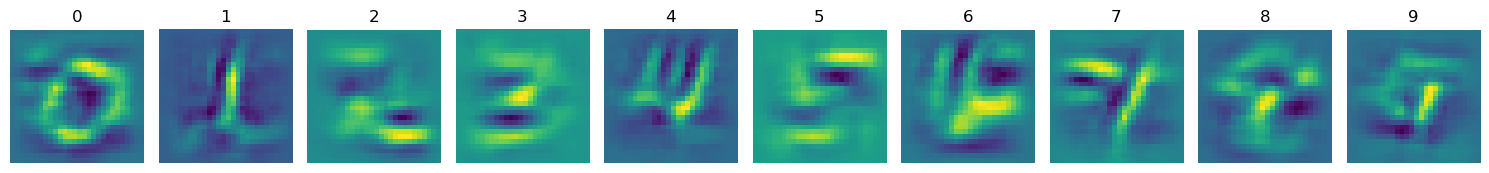

Iteration 26000 current batch loss: 0.010611729696393013
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99653, 0.996461, 0.998342, 0.997809, 0.997859, 0.998684, 0.997457, 0.997561, 0.998321, 0.996991]


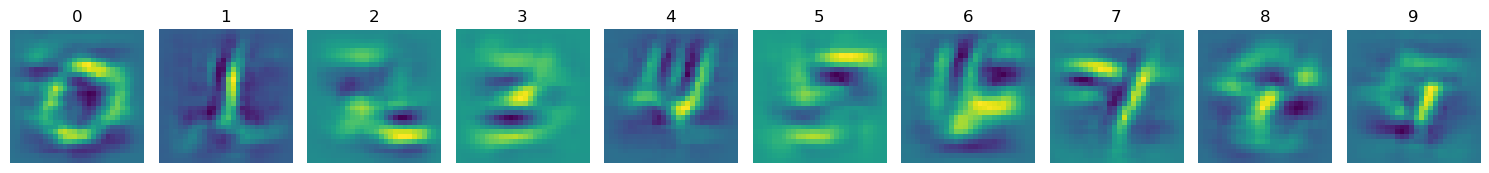

Iteration 28000 current batch loss: 0.010611733421683311
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99653, 0.996458, 0.998339, 0.997812, 0.997862, 0.998683, 0.997459, 0.997561, 0.998324, 0.99699]


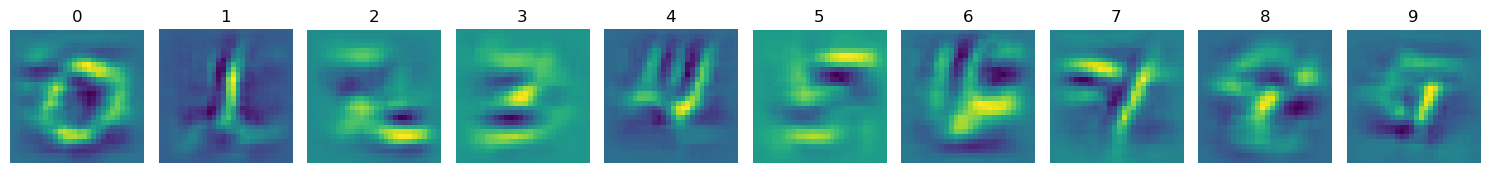

Iteration 30000 current batch loss: 0.010611681267619133
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996532, 0.996461, 0.998345, 0.997809, 0.99786, 0.998681, 0.997457, 0.997562, 0.998324, 0.996994]


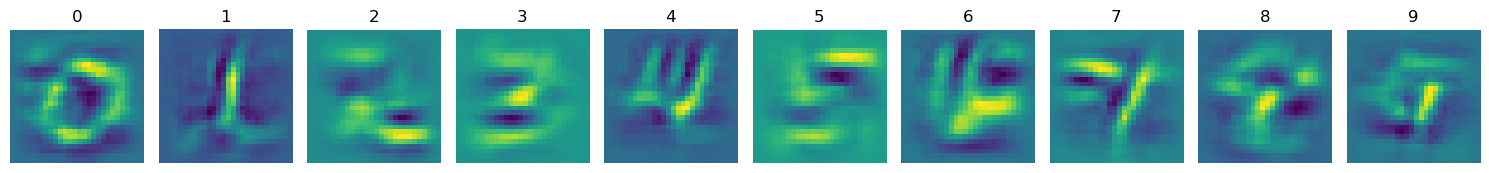

Iteration 32000 current batch loss: 0.010611677542328835
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996529, 0.99646, 0.998334, 0.99781, 0.997858, 0.998682, 0.997456, 0.997559, 0.998321, 0.996992]


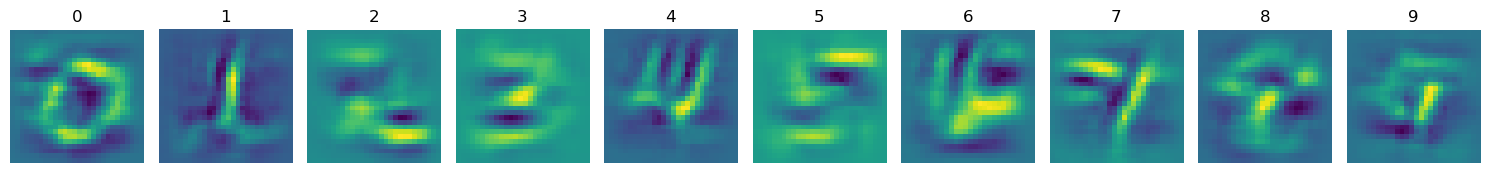

Iteration 34000 current batch loss: 0.01061165053397417
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996532, 0.996462, 0.998345, 0.997809, 0.997859, 0.998683, 0.997457, 0.997559, 0.998323, 0.996993]


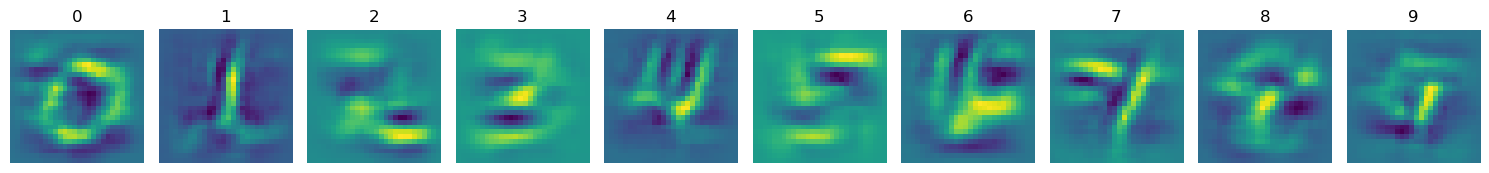

Iteration 36000 current batch loss: 0.01061161607503891
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996531, 0.996461, 0.998337, 0.997811, 0.997859, 0.998682, 0.997456, 0.997562, 0.998321, 0.996993]


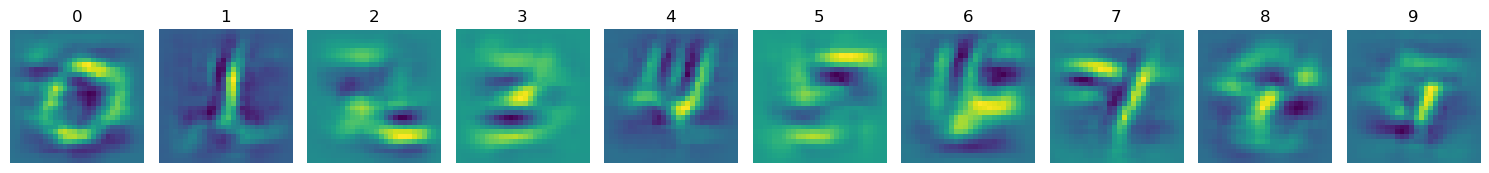

Iteration 38000 current batch loss: 0.010611757636070251
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99653, 0.996462, 0.998337, 0.997809, 0.997858, 0.998683, 0.997456, 0.997561, 0.998322, 0.996992]


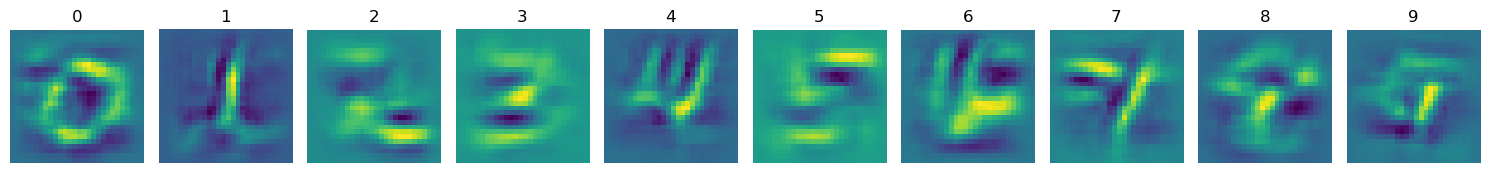

Iteration 40000 current batch loss: 0.010611639358103275
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996531, 0.996462, 0.99834, 0.99781, 0.99786, 0.998683, 0.997459, 0.99756, 0.998322, 0.996992]


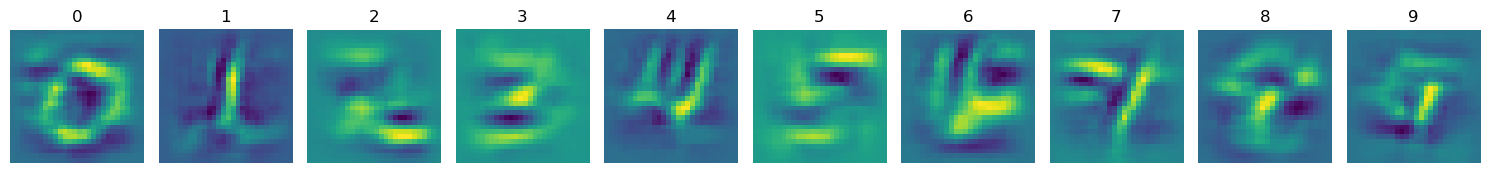

Iteration 40000 current batch loss: 0.010611639358103275


In [176]:
points_3 = train_input(net, lambda_l2 = 0.1, plot = True)

# $\lambda = 1$

Iteration 2000 current batch loss: 0.3772851228713989
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.970889, 0.926529, 0.978609, 0.968873, 0.970256, 0.984892, 0.972517, 0.977174, 0.987929, 0.95366]


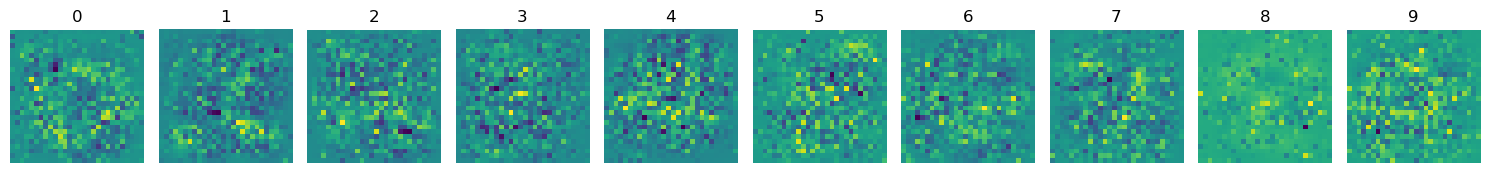

Iteration 4000 current batch loss: 0.12954533100128174
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97615, 0.958093, 0.984467, 0.975545, 0.980223, 0.989011, 0.980266, 0.983373, 0.98946, 0.968544]


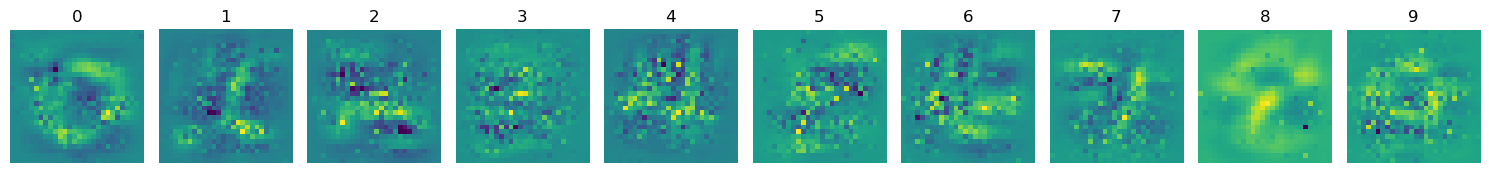

Iteration 6000 current batch loss: 0.07217098027467728
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977559, 0.96138, 0.986235, 0.981174, 0.984935, 0.990886, 0.981108, 0.983345, 0.989615, 0.977315]


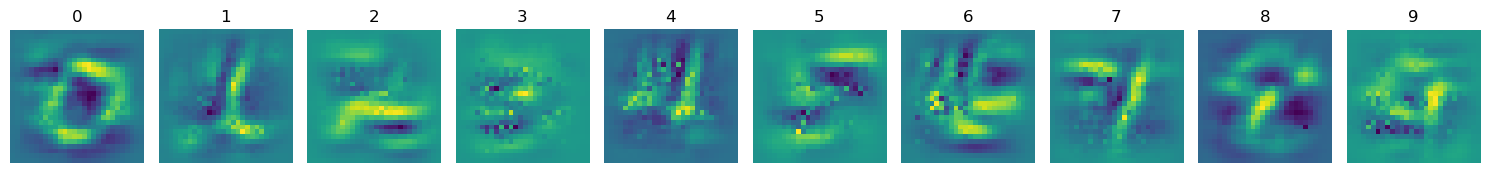

Iteration 8000 current batch loss: 0.06435588002204895
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977721, 0.964597, 0.98636, 0.984036, 0.985775, 0.991018, 0.981274, 0.983478, 0.989664, 0.978252]


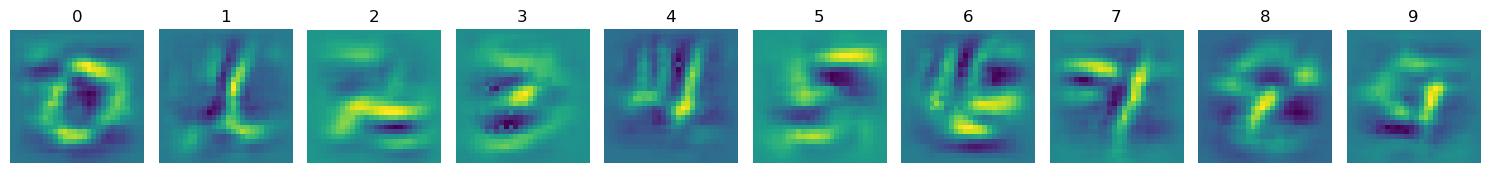

Iteration 10000 current batch loss: 0.06410148739814758
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977718, 0.964574, 0.986361, 0.984084, 0.985796, 0.991019, 0.98127, 0.983454, 0.989653, 0.978264]


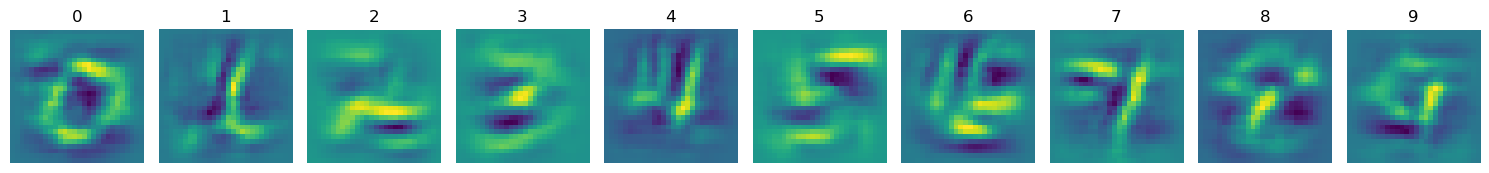

Iteration 12000 current batch loss: 0.0641007348895073
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97772, 0.96456, 0.986359, 0.984077, 0.985811, 0.991013, 0.98129, 0.983443, 0.989671, 0.978276]


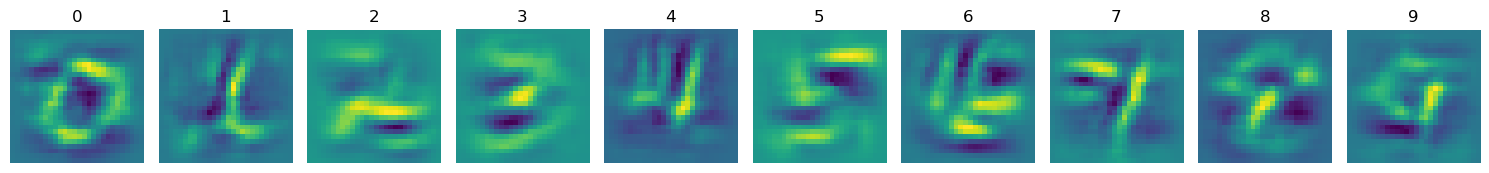

Iteration 14000 current batch loss: 0.06410139799118042
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977726, 0.964575, 0.98636, 0.984086, 0.985813, 0.991044, 0.981287, 0.983432, 0.989667, 0.978265]


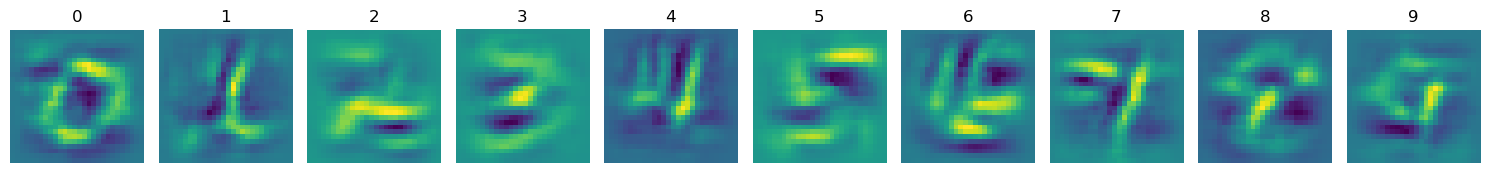

Iteration 16000 current batch loss: 0.06410100311040878
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977716, 0.964599, 0.986363, 0.984086, 0.985814, 0.99104, 0.981302, 0.983436, 0.989636, 0.978269]


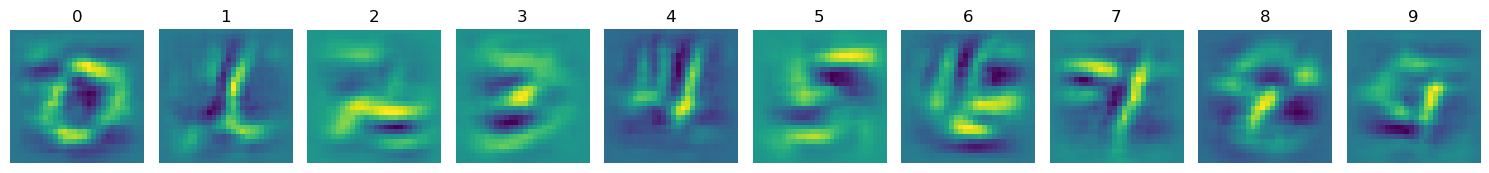

Iteration 18000 current batch loss: 0.06410187482833862
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977721, 0.964579, 0.986367, 0.984089, 0.985799, 0.991037, 0.981274, 0.983443, 0.989652, 0.978273]


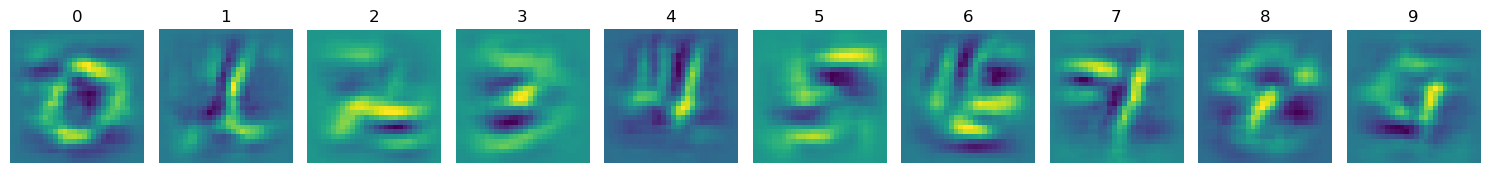

Iteration 20000 current batch loss: 0.06410074234008789
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977727, 0.964561, 0.986361, 0.984083, 0.985803, 0.991019, 0.981247, 0.983444, 0.98965, 0.978254]


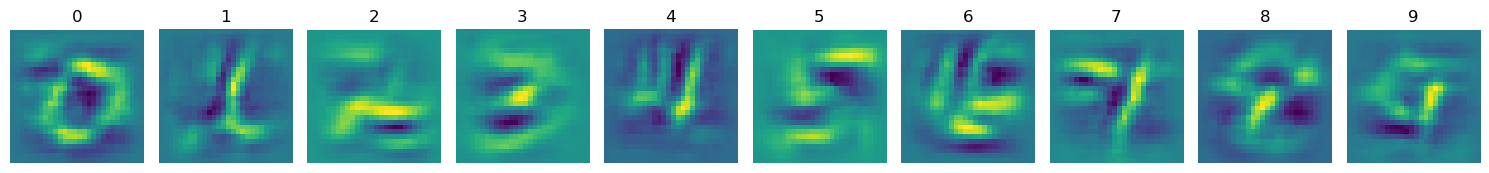

Iteration 22000 current batch loss: 0.0641012042760849
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977727, 0.96458, 0.986359, 0.984084, 0.985813, 0.991022, 0.981255, 0.983437, 0.989661, 0.978261]


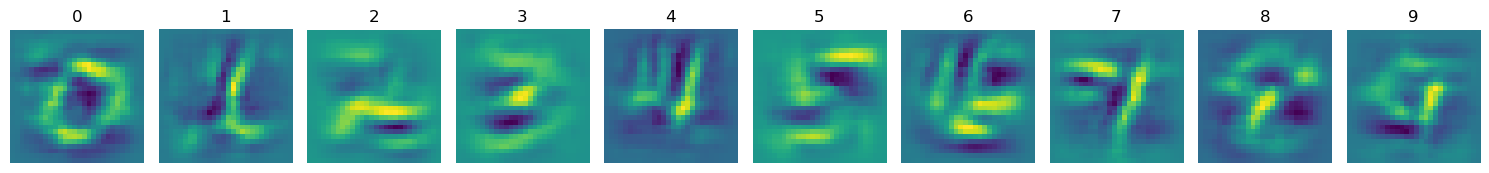

Iteration 24000 current batch loss: 0.06410147249698639
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977722, 0.964578, 0.98636, 0.984094, 0.985812, 0.991029, 0.981291, 0.983431, 0.989656, 0.978262]


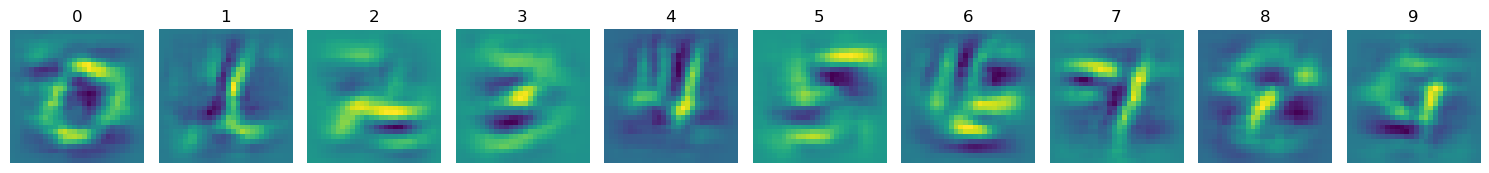

Iteration 26000 current batch loss: 0.0641004890203476
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977743, 0.964566, 0.986356, 0.984087, 0.985816, 0.991019, 0.981275, 0.983458, 0.989653, 0.978271]


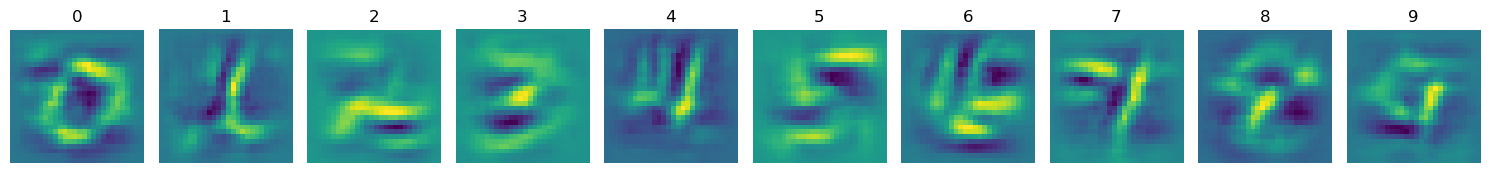

Iteration 28000 current batch loss: 0.06410083919763565
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977723, 0.964581, 0.986351, 0.984065, 0.985816, 0.99103, 0.98128, 0.983443, 0.98965, 0.978274]


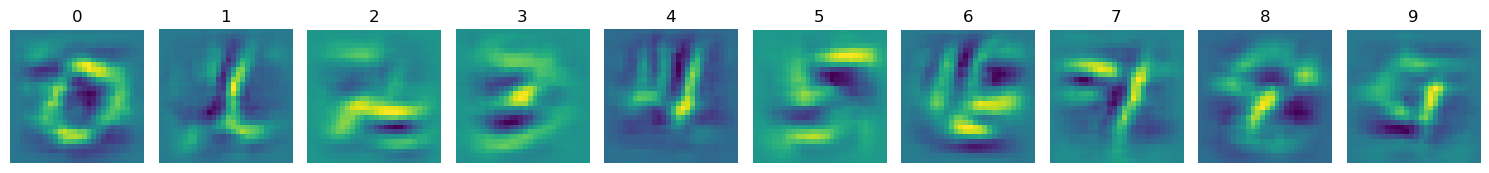

Iteration 30000 current batch loss: 0.06410102546215057
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977733, 0.964589, 0.986353, 0.984081, 0.985802, 0.991017, 0.981274, 0.98343, 0.989652, 0.97826]


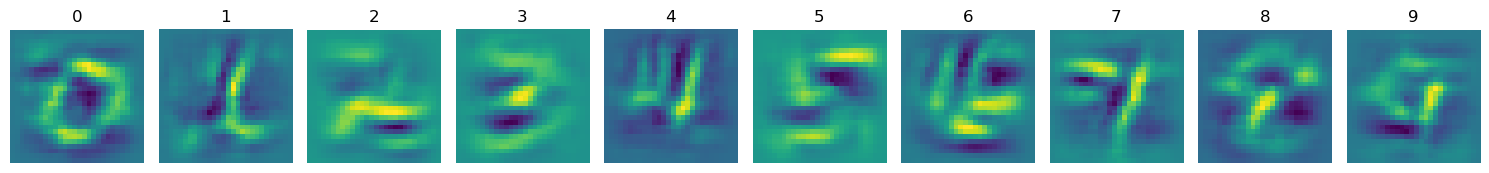

Iteration 32000 current batch loss: 0.06410123407840729
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977749, 0.964577, 0.986369, 0.984093, 0.985801, 0.991024, 0.981282, 0.983452, 0.989642, 0.978271]


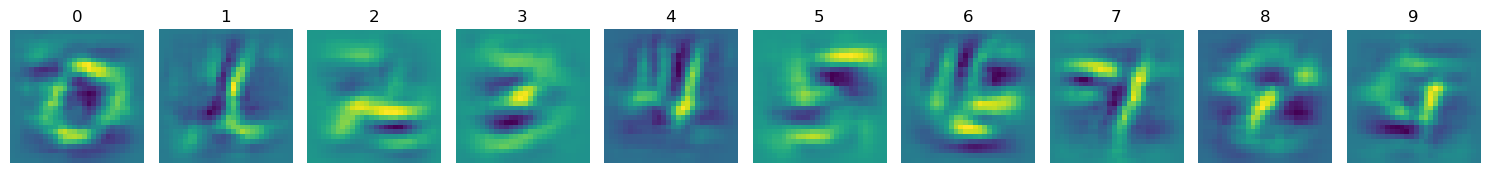

Iteration 34000 current batch loss: 0.0641002357006073
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977725, 0.964577, 0.986356, 0.984088, 0.985825, 0.991031, 0.981293, 0.983442, 0.989667, 0.978282]


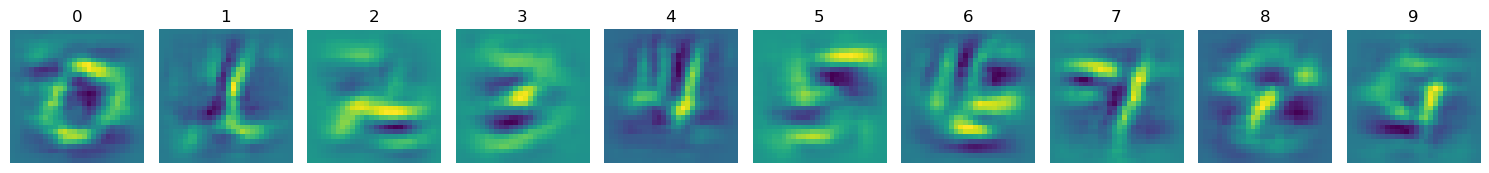

Iteration 36000 current batch loss: 0.06410175561904907
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977746, 0.964569, 0.986356, 0.984088, 0.985812, 0.991012, 0.981282, 0.983435, 0.989658, 0.978272]


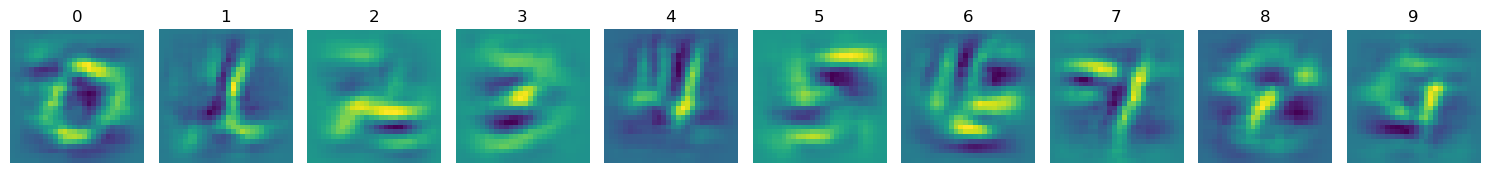

Iteration 38000 current batch loss: 0.06409964710474014
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977723, 0.964594, 0.986363, 0.984089, 0.985796, 0.991036, 0.981289, 0.983425, 0.98965, 0.978274]


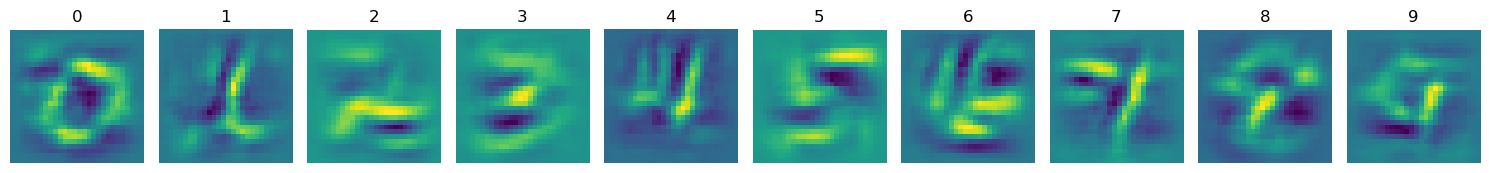

Iteration 40000 current batch loss: 0.06410080939531326
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.977737, 0.964566, 0.98636, 0.984085, 0.98583, 0.990987, 0.981281, 0.983457, 0.989656, 0.978258]


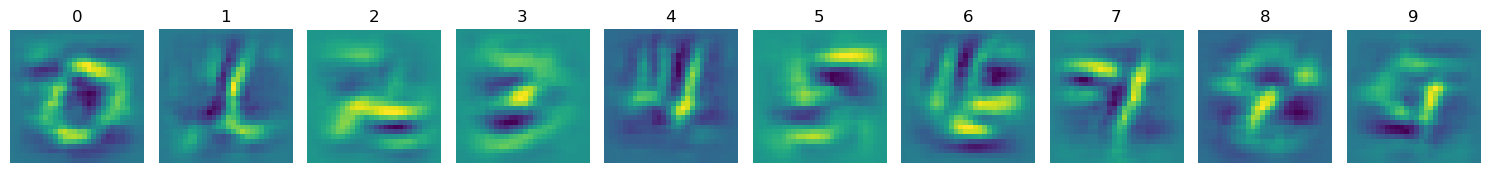

Iteration 40000 current batch loss: 0.06410080939531326


In [177]:
points_4 = train_input(net, lambda_l2 = 1, plot = True)

# $\lambda = 10$

Iteration 2000 current batch loss: 0.9307612180709839
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.864812, 0.722514, 0.904408, 0.884291, 0.864467, 0.930743, 0.866044, 0.833217, 0.947415, 0.833368]


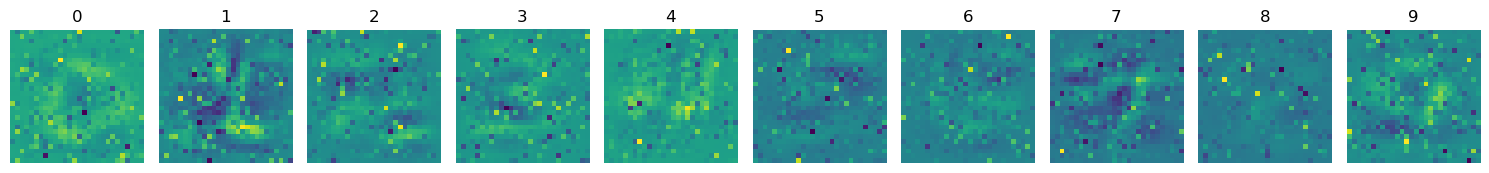

Iteration 4000 current batch loss: 0.33391332626342773
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.881483, 0.771255, 0.921975, 0.904234, 0.893942, 0.943243, 0.886821, 0.897842, 0.948812, 0.860186]


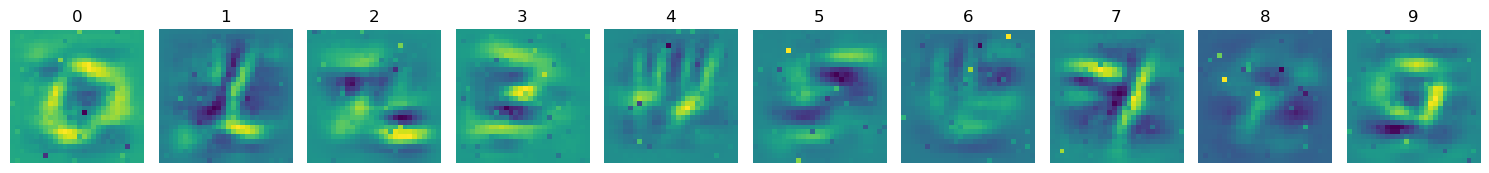

Iteration 6000 current batch loss: 0.31508028507232666
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.88228, 0.781561, 0.925047, 0.905569, 0.900062, 0.94485, 0.889302, 0.898776, 0.948414, 0.860461]


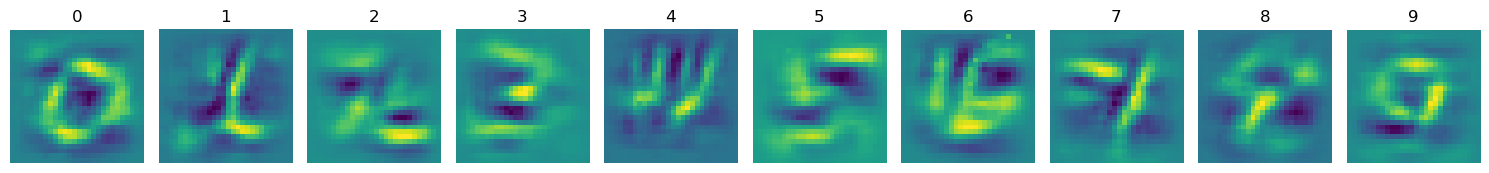

Iteration 8000 current batch loss: 0.31433090567588806
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882229, 0.786887, 0.925054, 0.905526, 0.90024, 0.944847, 0.889359, 0.898784, 0.948429, 0.860402]


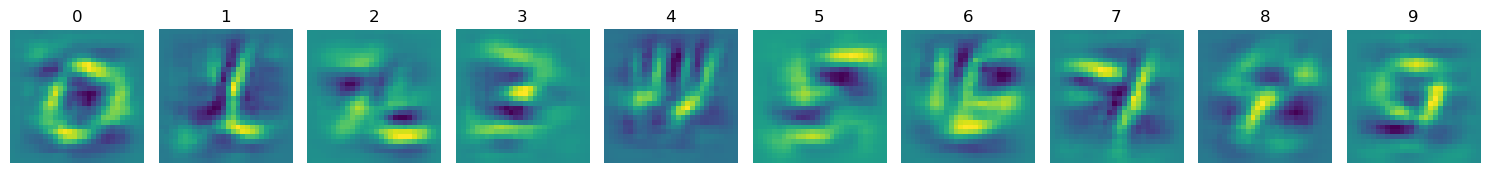

Iteration 10000 current batch loss: 0.31433534622192383
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882204, 0.786898, 0.925011, 0.905616, 0.90034, 0.944818, 0.889404, 0.898814, 0.948361, 0.860451]


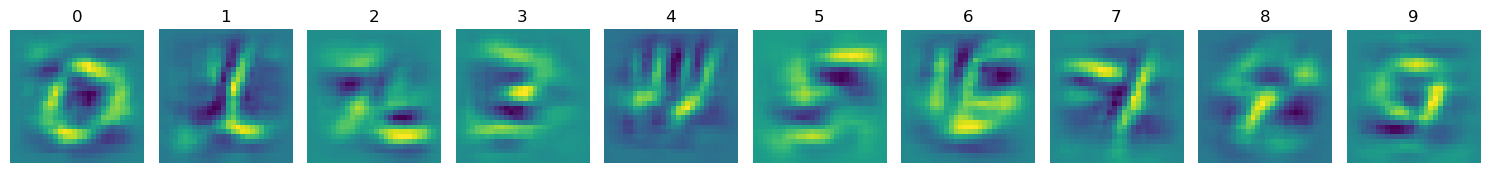

Iteration 12000 current batch loss: 0.3143378794193268
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.88225, 0.786985, 0.925261, 0.905564, 0.900278, 0.94488, 0.889347, 0.898856, 0.948404, 0.86053]


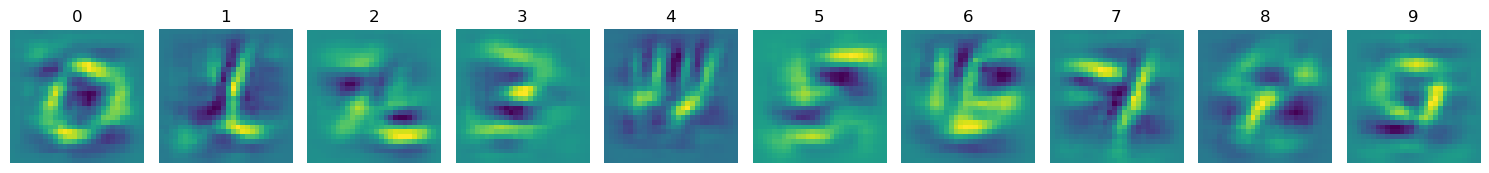

Iteration 14000 current batch loss: 0.31433624029159546
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.88216, 0.786918, 0.925009, 0.905597, 0.900339, 0.944799, 0.889351, 0.898778, 0.948384, 0.860445]


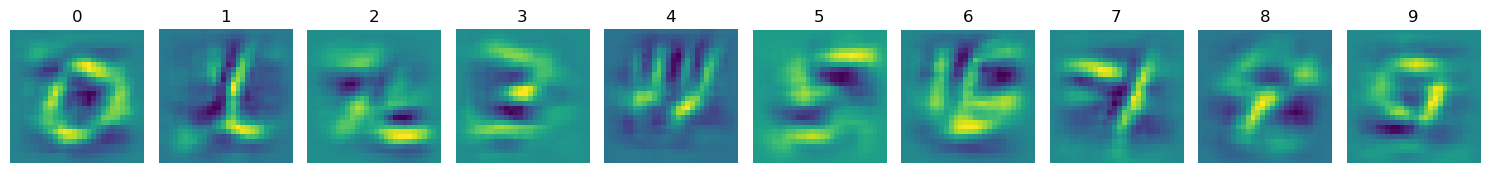

Iteration 16000 current batch loss: 0.31434041261672974
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882144, 0.787017, 0.925051, 0.905578, 0.900348, 0.944918, 0.889569, 0.898669, 0.948409, 0.860577]


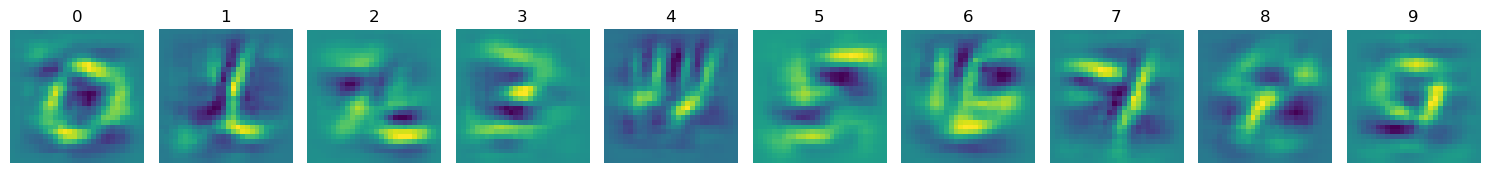

Iteration 18000 current batch loss: 0.31433796882629395
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882271, 0.786943, 0.92519, 0.905622, 0.900434, 0.944835, 0.889299, 0.898842, 0.948386, 0.860603]


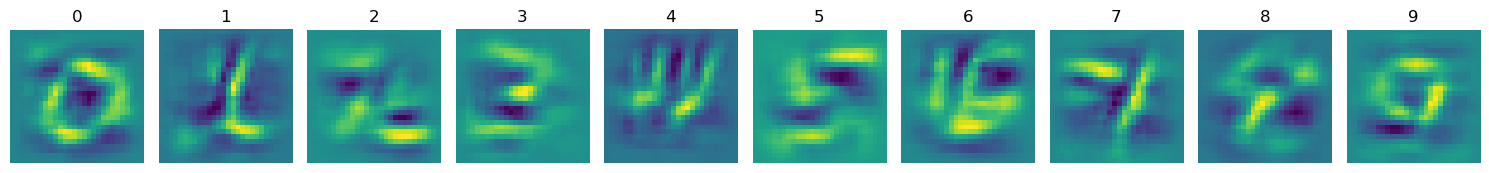

Iteration 20000 current batch loss: 0.31433629989624023
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882145, 0.786985, 0.925029, 0.905575, 0.900284, 0.944953, 0.889269, 0.898785, 0.948339, 0.860291]


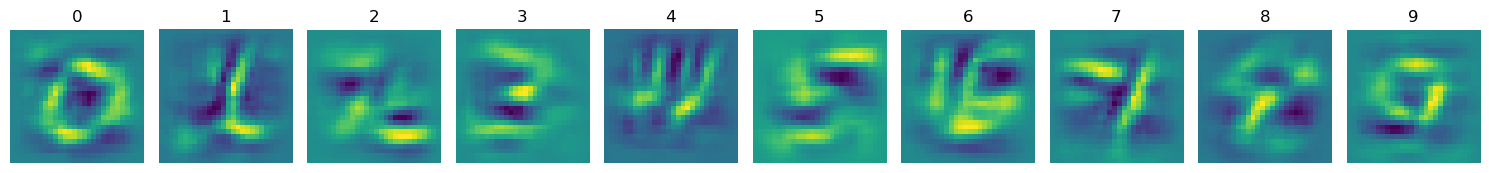

Iteration 22000 current batch loss: 0.3143419325351715
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882108, 0.786987, 0.925074, 0.905669, 0.900377, 0.944821, 0.889455, 0.898789, 0.948374, 0.86063]


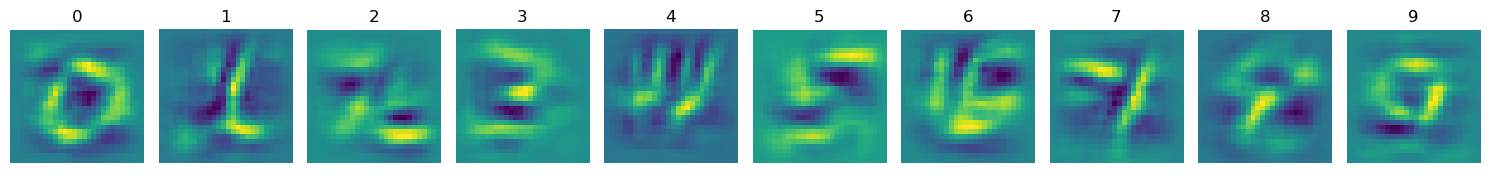

Iteration 24000 current batch loss: 0.3143382668495178
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882149, 0.787032, 0.92492, 0.905639, 0.900212, 0.944957, 0.889503, 0.898789, 0.948392, 0.860372]


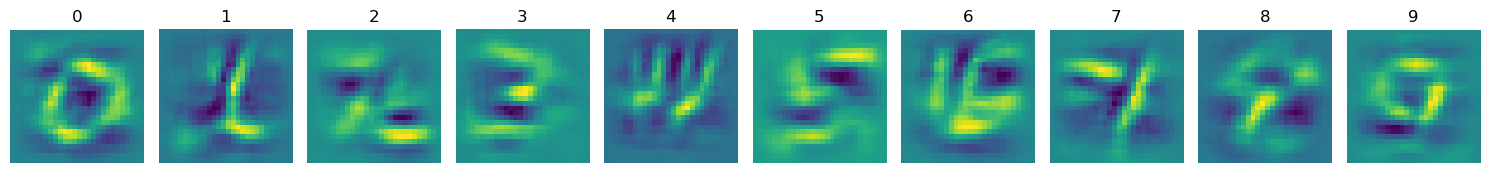

Iteration 26000 current batch loss: 0.314336359500885
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882181, 0.786804, 0.925174, 0.905509, 0.900391, 0.944793, 0.889415, 0.898753, 0.948403, 0.860362]


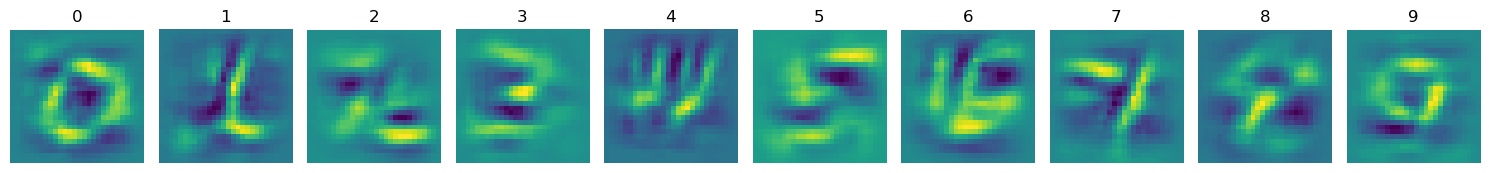

Iteration 28000 current batch loss: 0.3143388032913208
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.88222, 0.786914, 0.92478, 0.905602, 0.900365, 0.944796, 0.889286, 0.898823, 0.948376, 0.860505]


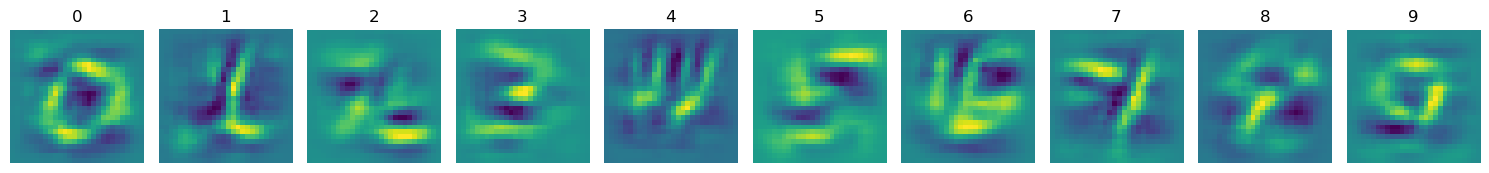

Iteration 30000 current batch loss: 0.31433477997779846
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882299, 0.786947, 0.924875, 0.905618, 0.900361, 0.944832, 0.889539, 0.898926, 0.948361, 0.86061]


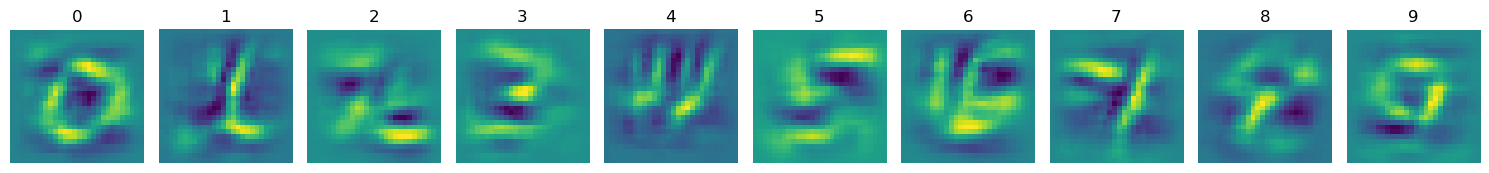

Iteration 32000 current batch loss: 0.31433790922164917
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882182, 0.787043, 0.925082, 0.905673, 0.900387, 0.944853, 0.889361, 0.89885, 0.948386, 0.860393]


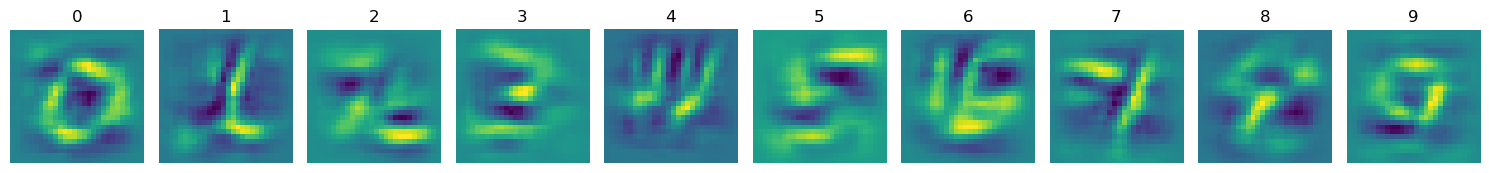

Iteration 34000 current batch loss: 0.3143347501754761
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.8822, 0.786991, 0.924947, 0.905623, 0.900308, 0.944846, 0.889443, 0.898713, 0.948382, 0.860515]


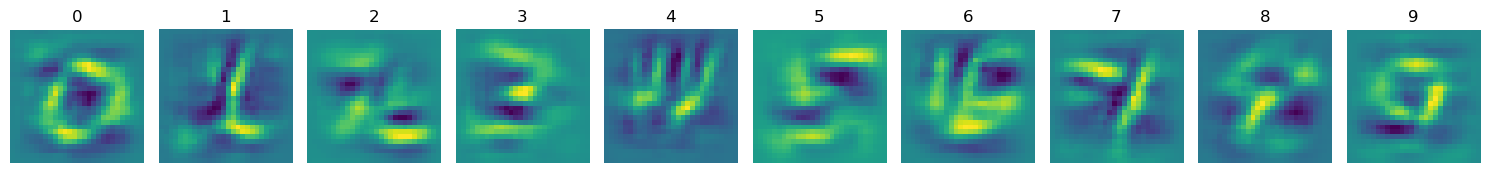

Iteration 36000 current batch loss: 0.31433284282684326
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882191, 0.786917, 0.924882, 0.905748, 0.900442, 0.944719, 0.88937, 0.898867, 0.948372, 0.860583]


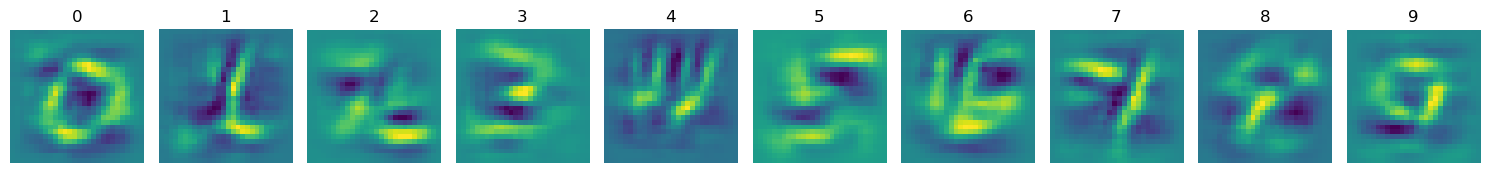

Iteration 38000 current batch loss: 0.31434181332588196
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882111, 0.786953, 0.925096, 0.905651, 0.900313, 0.944746, 0.889286, 0.898768, 0.948368, 0.860531]


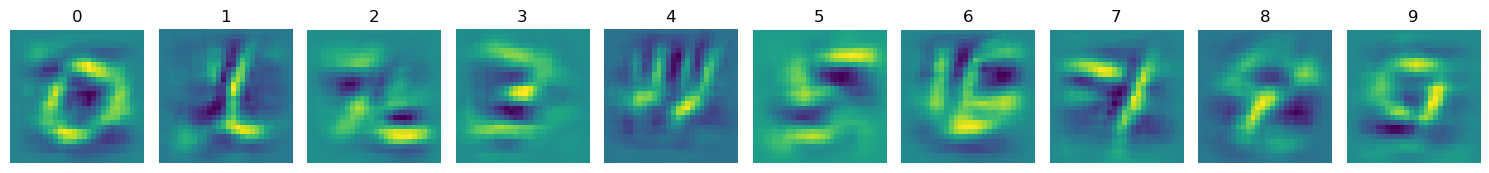

Iteration 40000 current batch loss: 0.3143409192562103
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.882154, 0.78685, 0.925095, 0.905634, 0.900218, 0.944784, 0.889387, 0.898775, 0.948357, 0.860477]


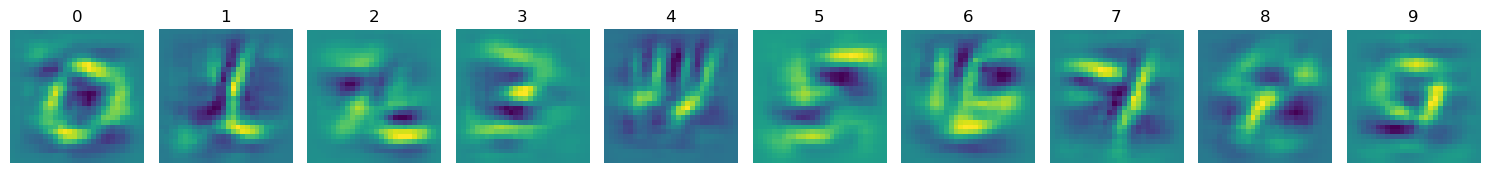

Iteration 40000 current batch loss: 0.3143409192562103


In [178]:
points_5 = train_input(net, lambda_l2 = 10, plot = True)

lambda = 0


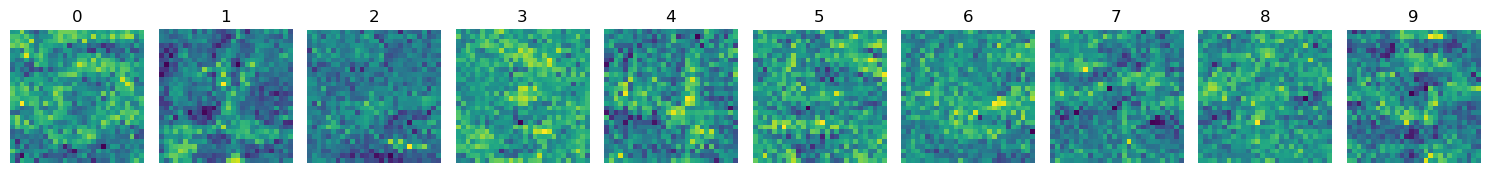

lambda = 0.01


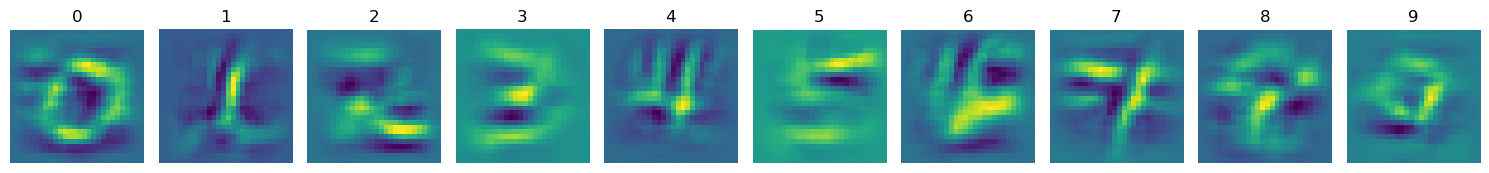

lambda = 0.1


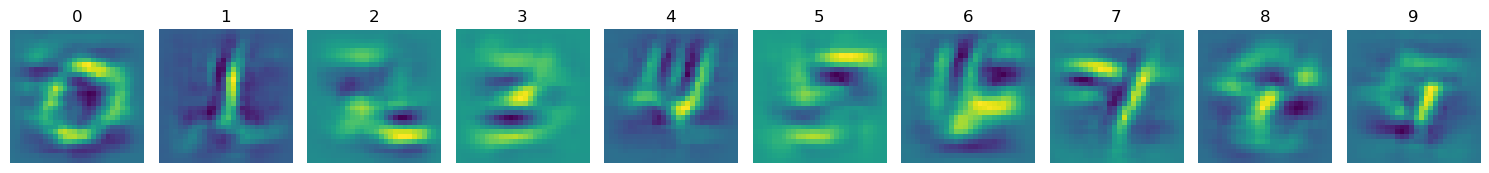

lambda = 1


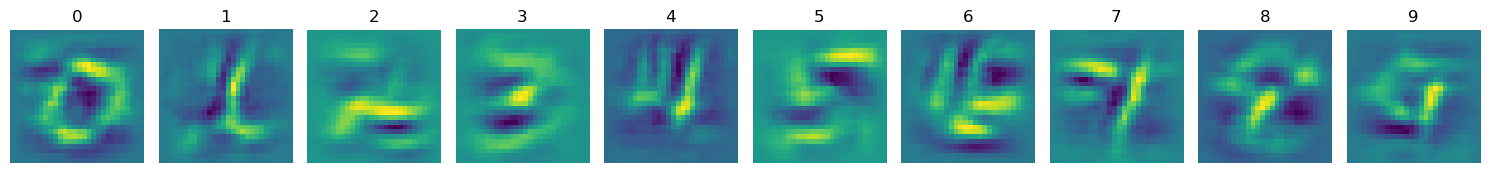

lambda = 10


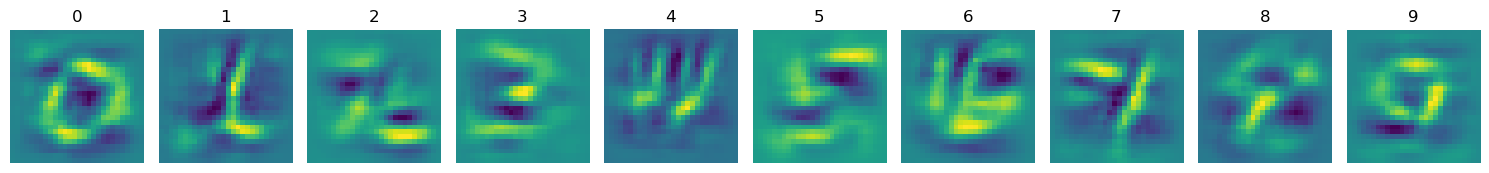

In [179]:
print("lambda = 0")
plot_numbers(points_1)
print("lambda = 0.01")
plot_numbers(points_2)
print("lambda = 0.1")
plot_numbers(points_3)
print("lambda = 1")
plot_numbers(points_4)
print("lambda = 10")
plot_numbers(points_5) # final plots

# Task 2

In [180]:
k = 9
targets = trainset.targets                  
idx_all = torch.cat([
    (targets == c).nonzero(as_tuple=True)[0][:k]  
    for c in range(10)
])

batch_imgs   = torch.stack([trainset[i][0] for i in idx_all])   
batch_labels = targets[idx_all]

for k in range(0,10):
    batch_labels[(9*k):9*(k + 1)] = torch.tensor([x for x in range(0, 10) if x != k])


batch_imgs = batch_imgs.to(device)
batch_labels = batch_labels.to(device)
print(batch_imgs.shape)   
print(batch_labels)       

torch.Size([90, 1, 28, 28])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
        7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
        0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')


In [181]:
tmp_example = batch_imgs[0]
tmp_label = batch_labels[0]

In [182]:
def plot_one_number(points):   # function for plotting

    img = points.squeeze().detach().cpu().numpy()
    pyplot.imshow(img)                 
    pyplot.tight_layout()
    pyplot.show()

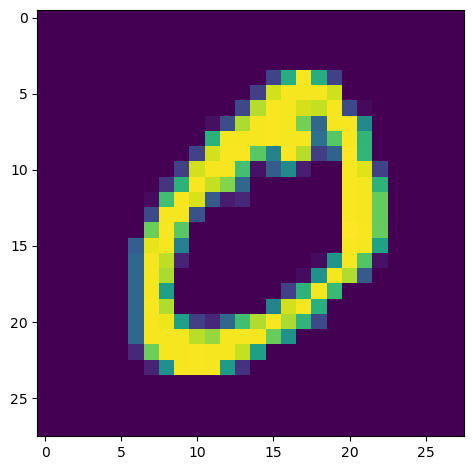

In [183]:
plot_one_number(tmp_example)

In [184]:
def train_noise(net, img, label, lr = 0.5, max_iter = 2000, info = 200, lambda_l2 = 10, plot = False):
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
        
    noise = torch.zeros(1, 28, 28).to(device)
    noise.requires_grad = True
    true = label    
    
    optimizer = torch.optim.Adam([noise], lr)
    
    epoch = 0
        
    while epoch < max_iter:
        
        optimizer.zero_grad()
        preds = net(img + noise)   
        loss = torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * noise.pow(2).mean()
    
        
        epoch += 1
        if epoch % info == 0:
            with torch.no_grad():
                print("Iteration", epoch, "current batch loss:", loss.item())
                print(torch.argmax(net(img + noise)))
                if plot:
                    plot_one_number(img + noise)
            
            loss.backward()     
            optimizer.step()     
    
    print("Iteration", epoch, "current batch loss:", loss.item())
        
    for parameters in net.parameters():
            parameters.requires_grad = True  # unfreezing model
    return noise + img

Iteration 2000 current batch loss: 21.52158546447754
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 1.6475011110305786
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.5361542105674744
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.8867825269699097
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.8867825269699097


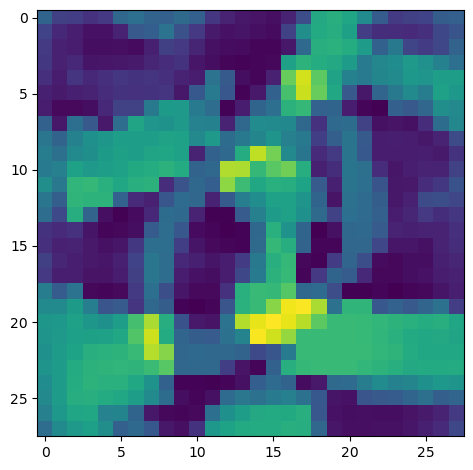

Iteration 2000 current batch loss: 11.178863525390625
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 1.1777633428573608
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.4539822041988373
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7275095582008362
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7275095582008362


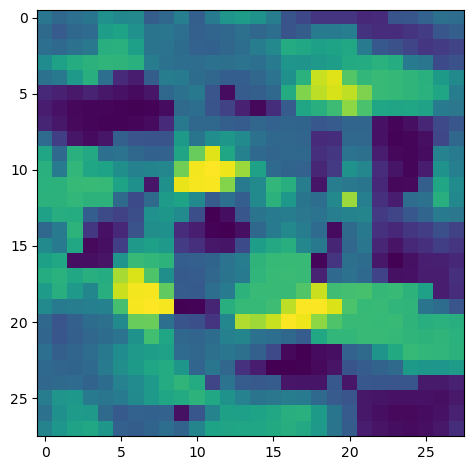

Iteration 2000 current batch loss: 13.324020385742188
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 0.2117883861064911
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.5323970913887024
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7651124596595764
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7651124596595764


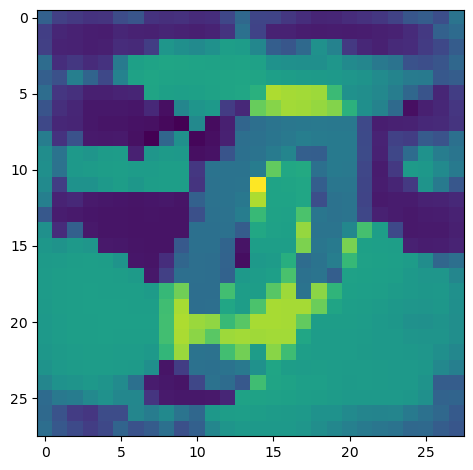

Iteration 2000 current batch loss: 14.353270530700684
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 0.32316648960113525
tensor(4, device='cuda:0')
Iteration 6000 current batch loss: 0.5489192008972168
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.8316642045974731
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.8316642045974731


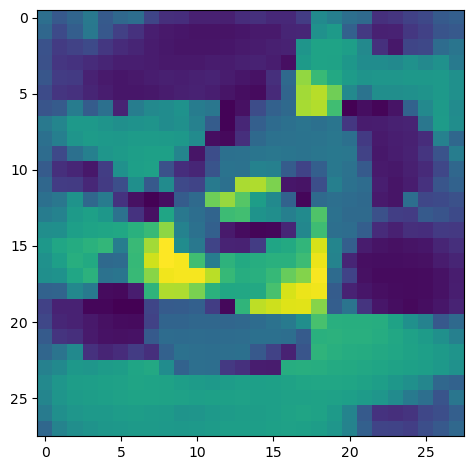

Iteration 2000 current batch loss: 18.50245475769043
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 0.21413654088974
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.5357085466384888
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8142725229263306
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8142725229263306


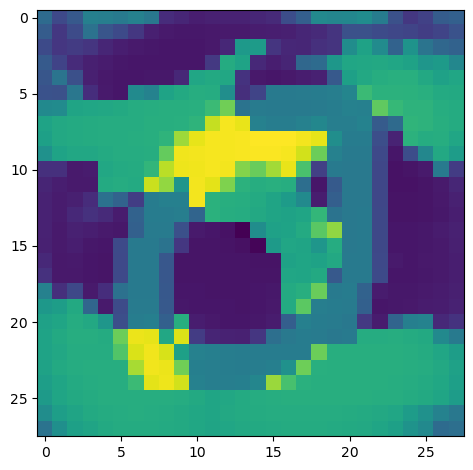

Iteration 2000 current batch loss: 15.221606254577637
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 5.7718071937561035
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 2.4983580112457275
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8573871850967407
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.8573871850967407


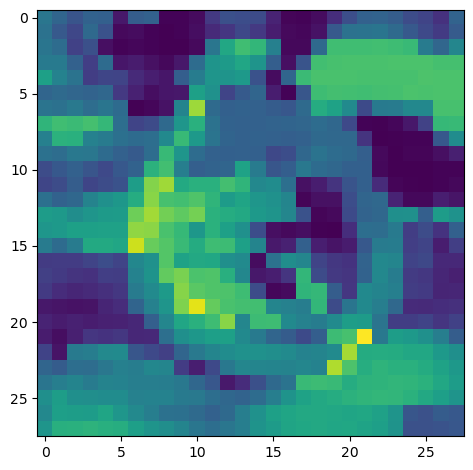

Iteration 2000 current batch loss: 12.614190101623535
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 0.47237294912338257
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.518310546875
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8304383158683777
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8304383158683777


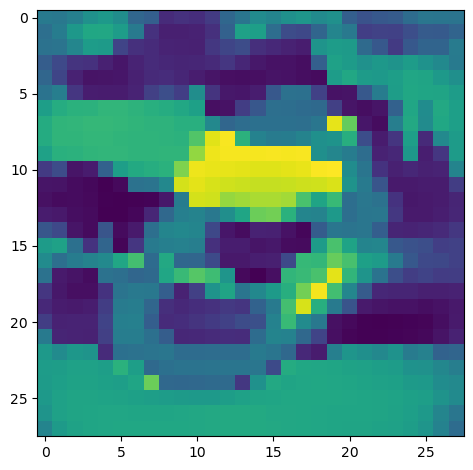

Iteration 2000 current batch loss: 9.438514709472656
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 0.9722676873207092
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.43509092926979065
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.7000554203987122
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.7000554203987122


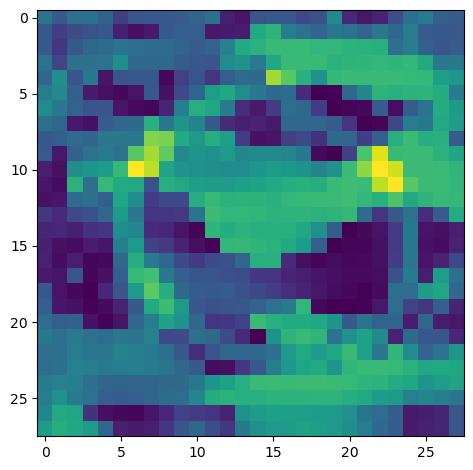

Iteration 2000 current batch loss: 12.456982612609863
tensor(0, device='cuda:0')
Iteration 4000 current batch loss: 0.20339088141918182
tensor(9, device='cuda:0')
Iteration 6000 current batch loss: 0.48906654119491577
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7597616910934448
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7597616910934448


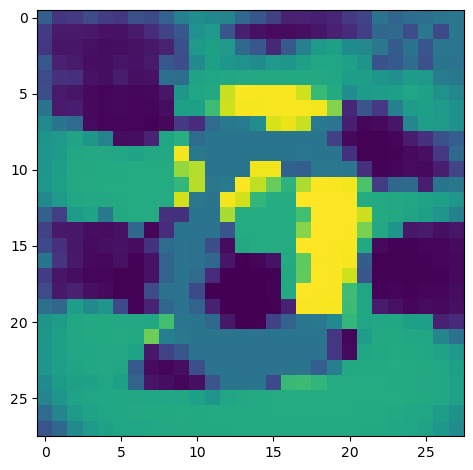

Iteration 2000 current batch loss: 10.910759925842285
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 0.32181113958358765
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.5093089938163757
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.8043617606163025
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.8043617606163025


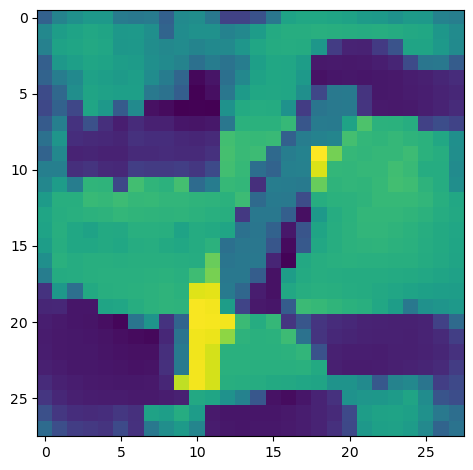

Iteration 2000 current batch loss: 10.666823387145996
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 0.20013399422168732
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.510447084903717
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8083834648132324
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8083834648132324


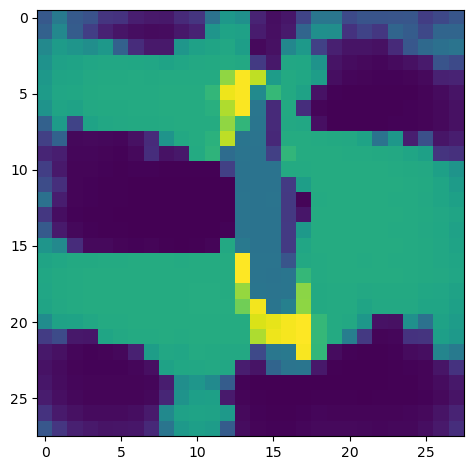

Iteration 2000 current batch loss: 9.978211402893066
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 0.2618095576763153
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.5147595405578613
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8155510425567627
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8155510425567627


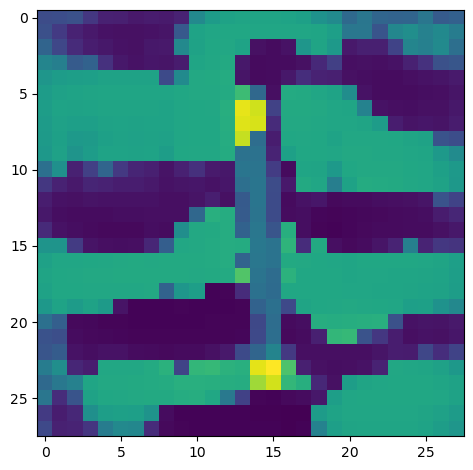

Iteration 2000 current batch loss: 7.777159690856934
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 4.541005611419678
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.3883765637874603
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6292609572410583
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6292609572410583


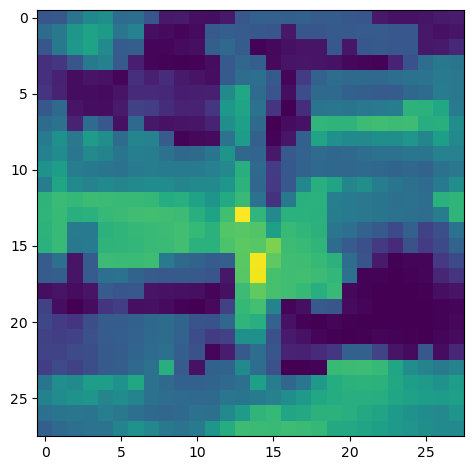

Iteration 2000 current batch loss: 14.73853874206543
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 0.8540772199630737
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.4611975848674774
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.7517117261886597
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.7517117261886597


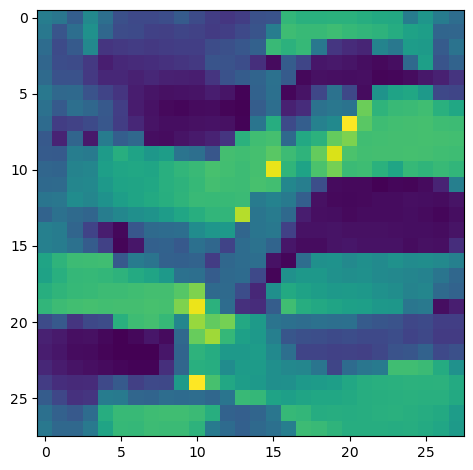

Iteration 2000 current batch loss: 11.633184432983398
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.2000238001346588
tensor(6, device='cuda:0')
Iteration 6000 current batch loss: 0.4971409738063812
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7831445932388306
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7831445932388306


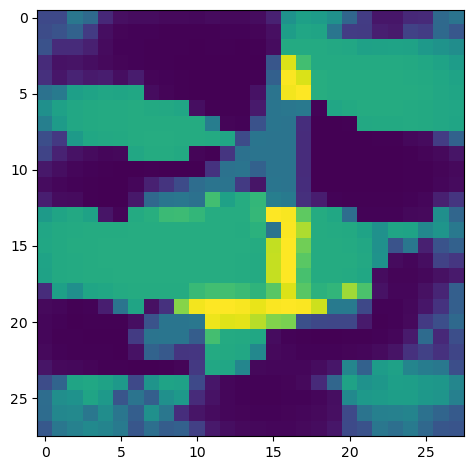

Iteration 2000 current batch loss: 9.166061401367188
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 0.22158174216747284
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5390072464942932
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8265361189842224
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8265361189842224


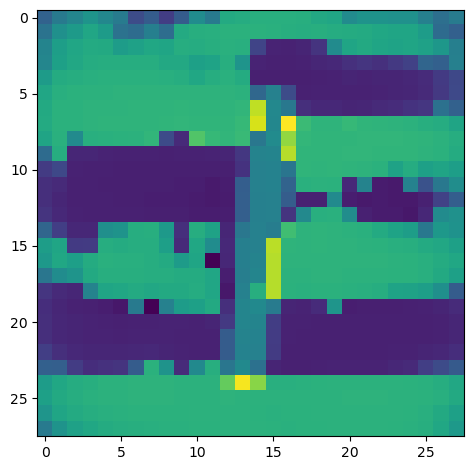

Iteration 2000 current batch loss: 6.641229152679443
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 0.20168422162532806
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.5136149525642395
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8152729868888855
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8152729868888855


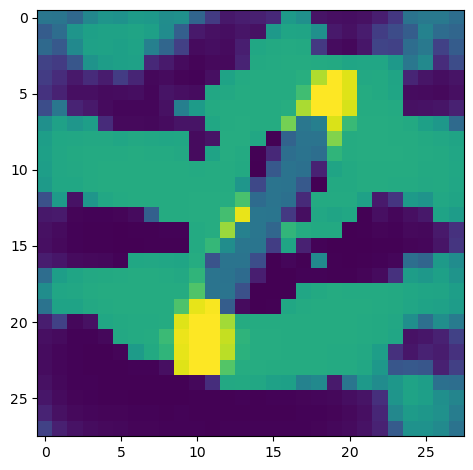

Iteration 2000 current batch loss: 7.997344017028809
tensor(1, device='cuda:0')
Iteration 4000 current batch loss: 0.2075231969356537
tensor(9, device='cuda:0')
Iteration 6000 current batch loss: 0.5264515280723572
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.8391944766044617
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.8391944766044617


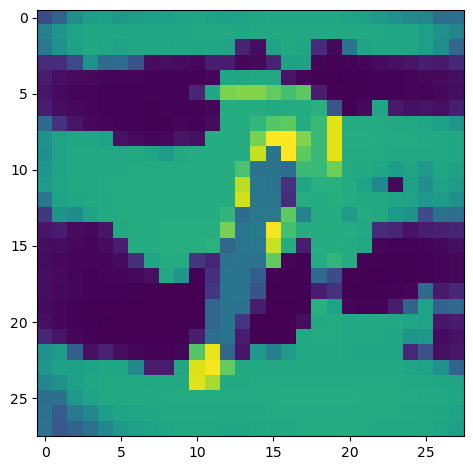

Iteration 2000 current batch loss: 12.018905639648438
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 0.47401124238967896
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.49864140152931213
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.7639028429985046
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.7639028429985046


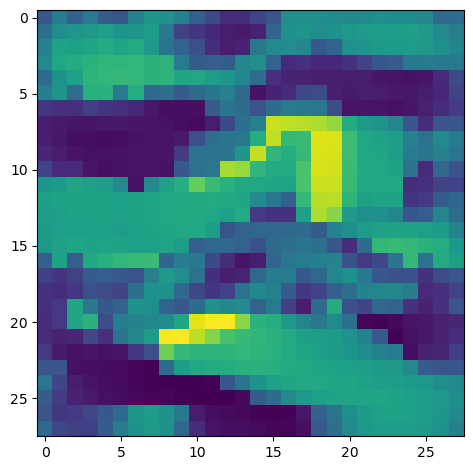

Iteration 2000 current batch loss: 17.134965896606445
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 1.5207165479660034
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.547910749912262
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.8906949758529663
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.8906949758529663


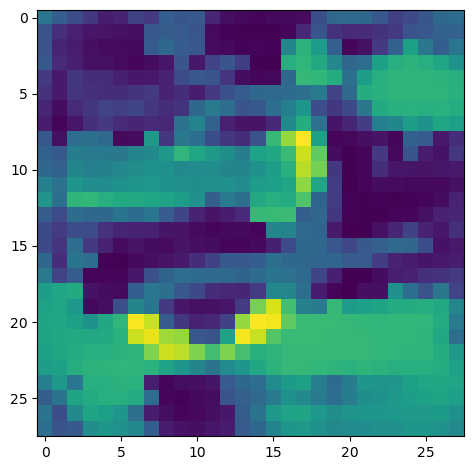

Iteration 2000 current batch loss: 6.726024150848389
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 0.2008102387189865
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.4871911108493805
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7555656433105469
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7555656433105469


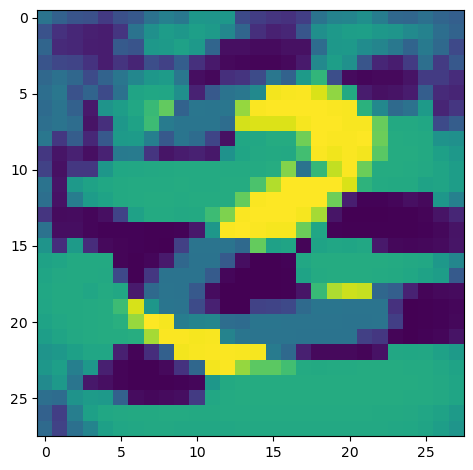

Iteration 2000 current batch loss: 28.047941207885742
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 16.47307586669922
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 4.848189353942871
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.7414340376853943
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.7414340376853943


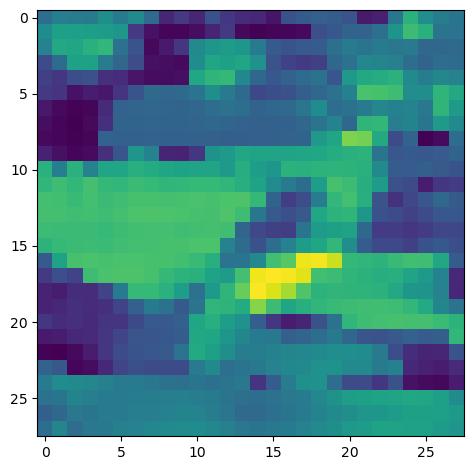

Iteration 2000 current batch loss: 19.290040969848633
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 0.20262610912322998
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.5114194750785828
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8168421387672424
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8168421387672424


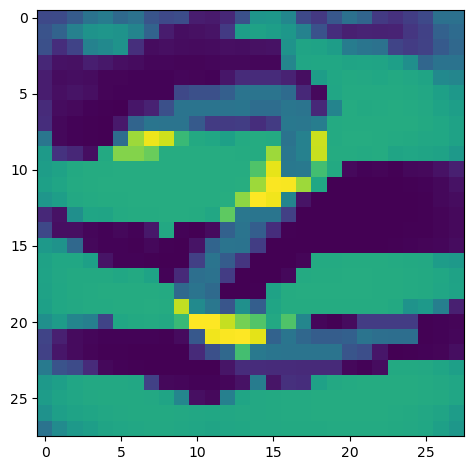

Iteration 2000 current batch loss: 27.269567489624023
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 0.20009033381938934
tensor(6, device='cuda:0')
Iteration 6000 current batch loss: 0.5068319439888
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7984980344772339
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7984980344772339


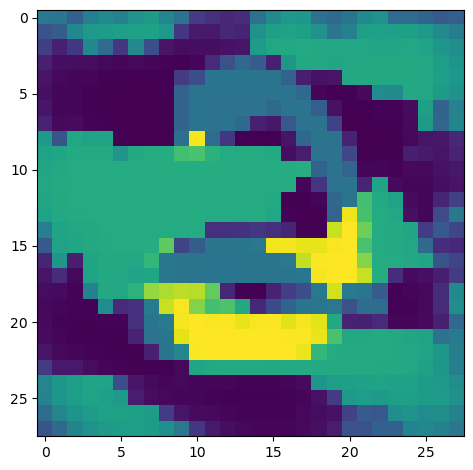

Iteration 2000 current batch loss: 5.505721092224121
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 0.20105388760566711
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.48844069242477417
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.7571324706077576
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.7571324706077576


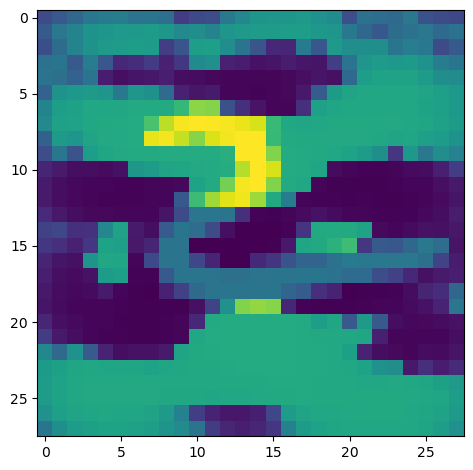

Iteration 2000 current batch loss: 12.205756187438965
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 0.2310507595539093
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.6271159648895264
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.805342435836792
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.805342435836792


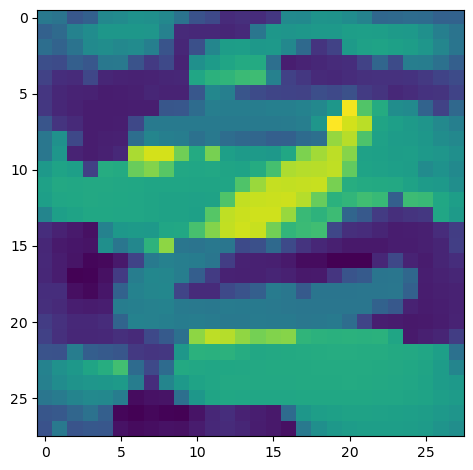

Iteration 2000 current batch loss: 17.056251525878906
tensor(2, device='cuda:0')
Iteration 4000 current batch loss: 1.8380823135375977
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5054288506507874
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.8532593250274658
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.8532593250274658


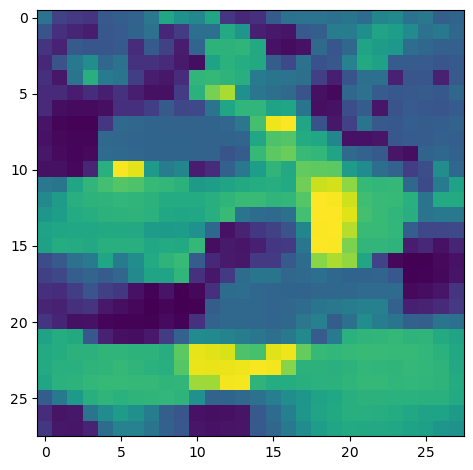

Iteration 2000 current batch loss: 20.508588790893555
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.3224056661128998
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.5189170241355896
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.8183348178863525
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.8183348178863525


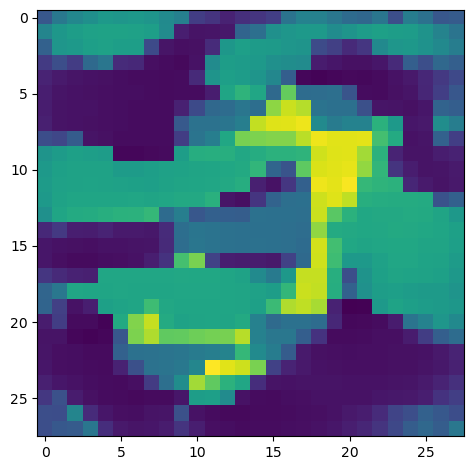

Iteration 2000 current batch loss: 13.431831359863281
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.2260003685951233
tensor(1, device='cuda:0')
Iteration 6000 current batch loss: 0.5142585039138794
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7957965135574341
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7957965135574341


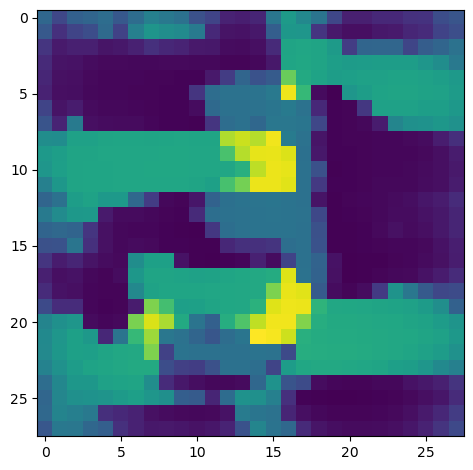

Iteration 2000 current batch loss: 15.226035118103027
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.2002434879541397
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.4826127588748932
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7361034154891968
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7361034154891968


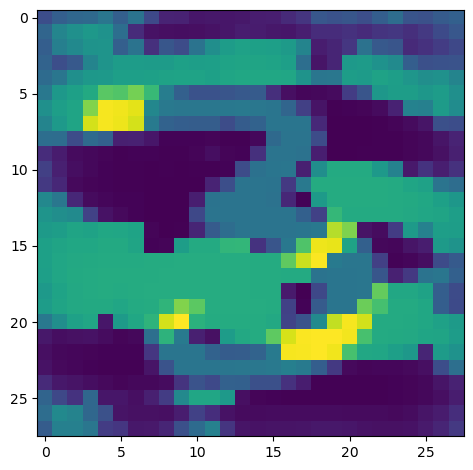

Iteration 2000 current batch loss: 36.20515823364258
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 7.617861747741699
tensor(9, device='cuda:0')
Iteration 6000 current batch loss: 0.577903151512146
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 1.0024018287658691
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 1.0024018287658691


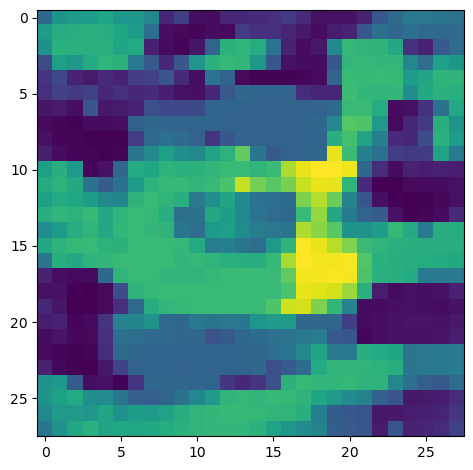

Iteration 2000 current batch loss: 12.330038070678711
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.6193700432777405
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.5229213237762451
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8401362299919128
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8401362299919128


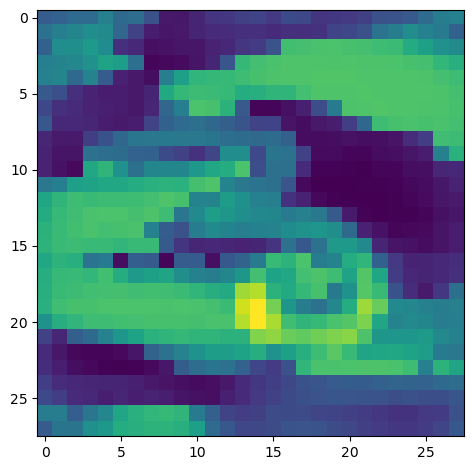

Iteration 2000 current batch loss: 23.946529388427734
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.7697243690490723
tensor(6, device='cuda:0')
Iteration 6000 current batch loss: 0.5155320763587952
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.849453330039978
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.849453330039978


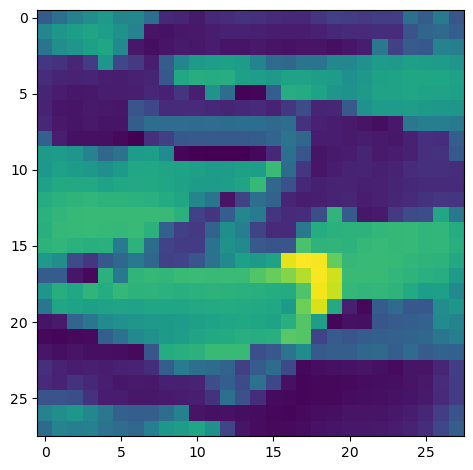

Iteration 2000 current batch loss: 16.652339935302734
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 2.1902248859405518
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.49910956621170044
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8506905436515808
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8506905436515808


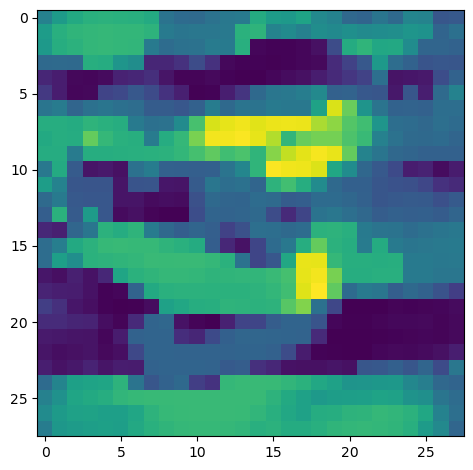

Iteration 2000 current batch loss: 9.6702880859375
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.23072436451911926
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 1.298317313194275
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7338690757751465
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.7338690757751465


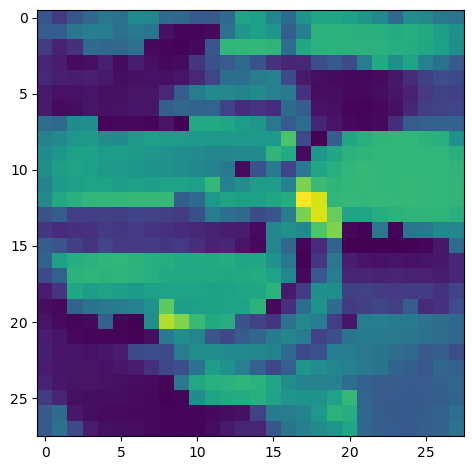

Iteration 2000 current batch loss: 9.978985786437988
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.200027734041214
tensor(9, device='cuda:0')
Iteration 6000 current batch loss: 0.5024662017822266
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.794224202632904
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.794224202632904


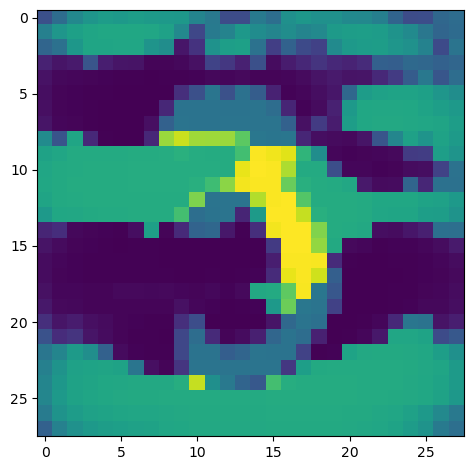

Iteration 2000 current batch loss: 14.906688690185547
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 3.712887763977051
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.45730459690093994
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.7419340014457703
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.7419340014457703


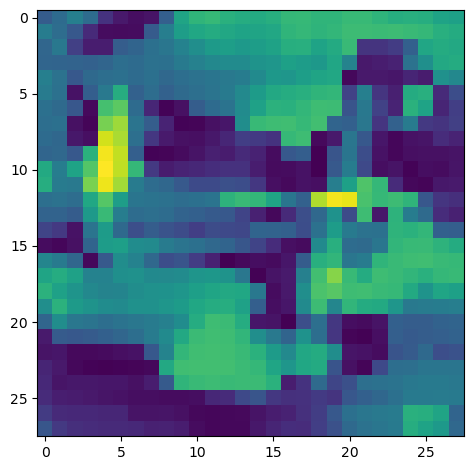

Iteration 2000 current batch loss: 17.84394073486328
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 7.189501762390137
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5977839231491089
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7679139375686646
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7679139375686646


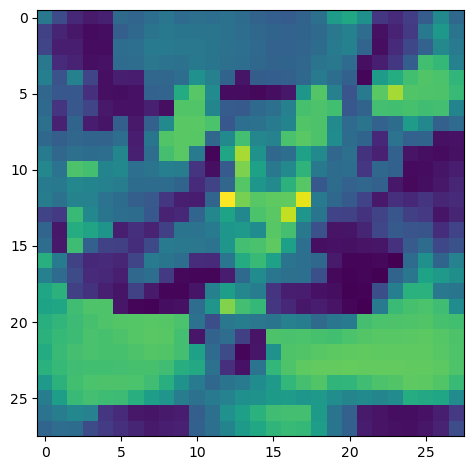

Iteration 2000 current batch loss: 11.022662162780762
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 0.20001347362995148
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.5053578019142151
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7936888337135315
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7936888337135315


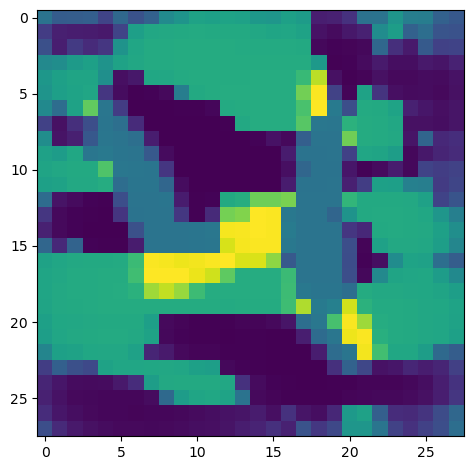

Iteration 2000 current batch loss: 11.186026573181152
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 0.20008742809295654
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.5171450972557068
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8328949213027954
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8328949213027954


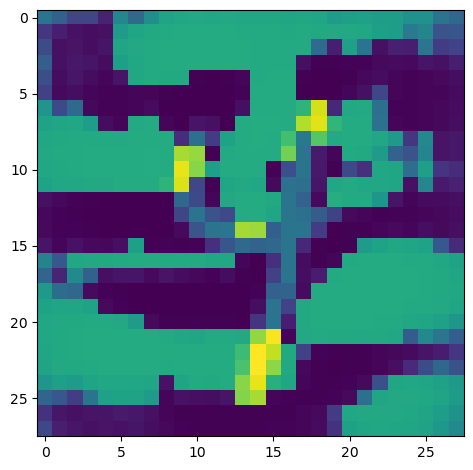

Iteration 2000 current batch loss: 11.06966495513916
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 0.2660258114337921
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.5141043663024902
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8093565106391907
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8093565106391907


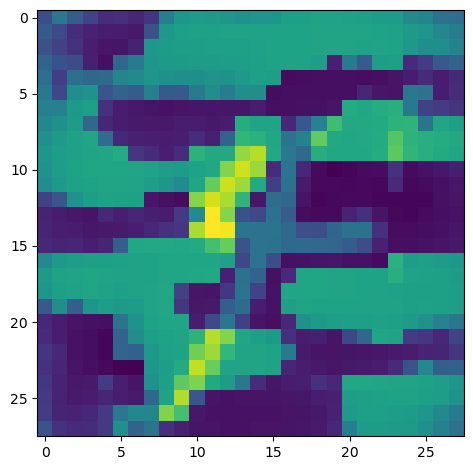

Iteration 2000 current batch loss: 21.033828735351562
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 0.5000309348106384
tensor(6, device='cuda:0')
Iteration 6000 current batch loss: 0.5310238003730774
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.881538987159729
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.881538987159729


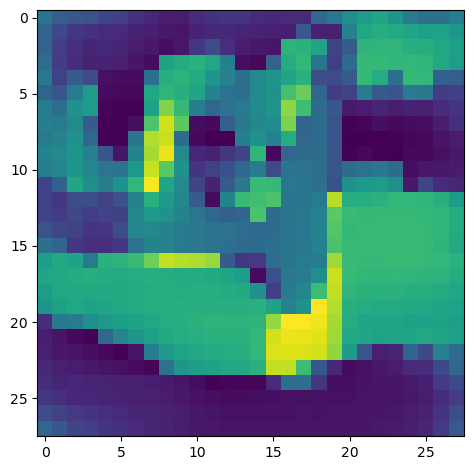

Iteration 2000 current batch loss: 11.035608291625977
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 0.22342677414417267
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5023705363273621
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.7746446132659912
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.7746446132659912


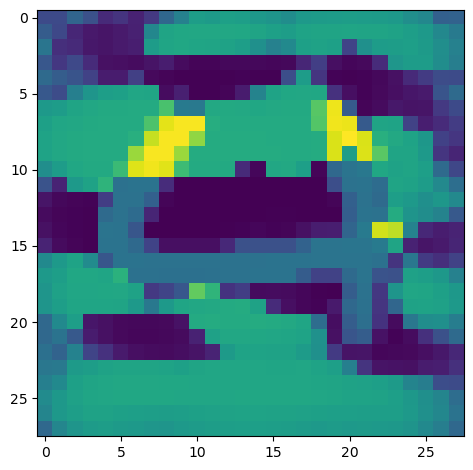

Iteration 2000 current batch loss: 9.060856819152832
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 0.23873132467269897
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.7731159329414368
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.879550576210022
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.879550576210022


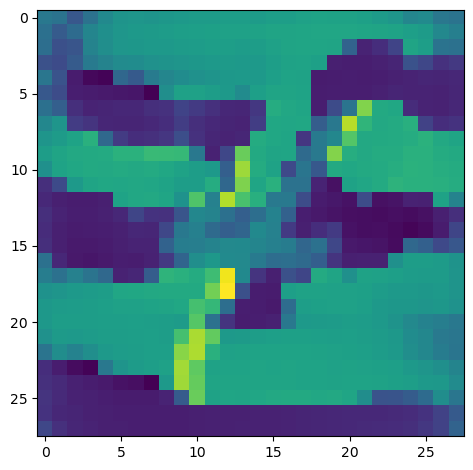

Iteration 2000 current batch loss: 10.569937705993652
tensor(4, device='cuda:0')
Iteration 4000 current batch loss: 0.24093681573867798
tensor(9, device='cuda:0')
Iteration 6000 current batch loss: 1.428415298461914
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8218755722045898
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.8218755722045898


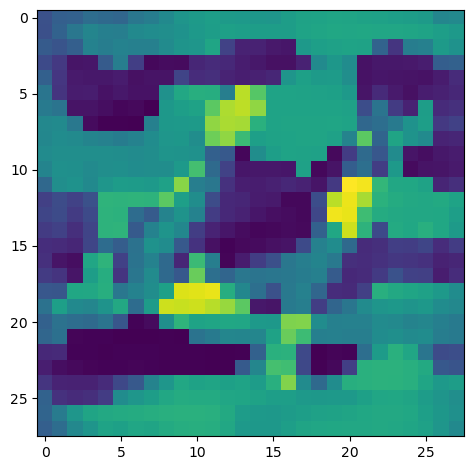

Iteration 2000 current batch loss: 12.779026985168457
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 11.419955253601074
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.6069667339324951
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.6995943784713745
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.6995943784713745


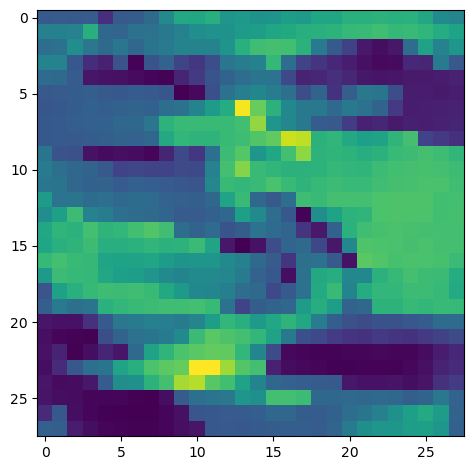

Iteration 2000 current batch loss: 9.083301544189453
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 13.273157119750977
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 2.1808013916015625
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.6359108686447144
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.6359108686447144


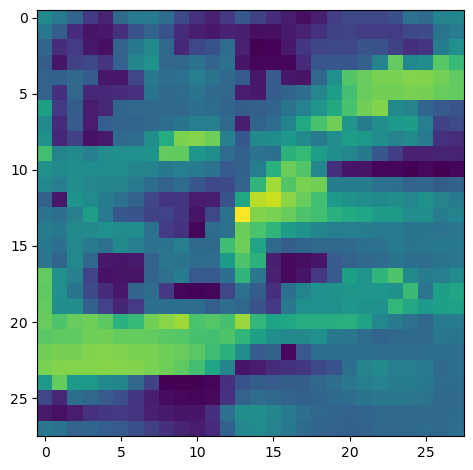

Iteration 2000 current batch loss: 12.025543212890625
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 0.200069397687912
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.5084655284881592
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8095297813415527
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8095297813415527


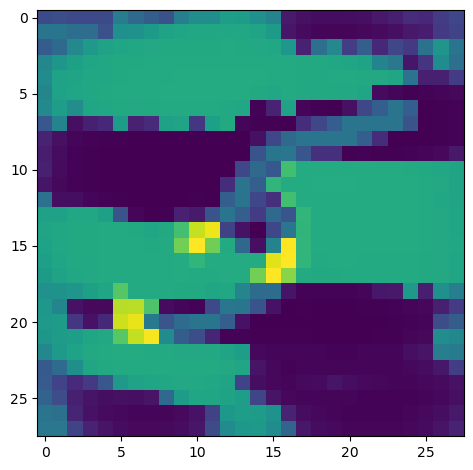

Iteration 2000 current batch loss: 11.581960678100586
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 0.2054007351398468
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.5888007283210754
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8122156262397766
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8122156262397766


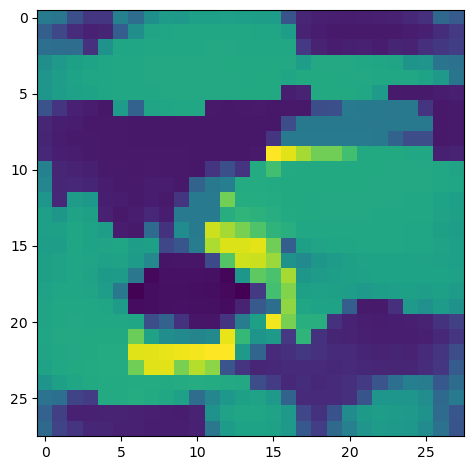

Iteration 2000 current batch loss: 14.064252853393555
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 8.119207382202148
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.4047081768512726
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6683856248855591
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6683856248855591


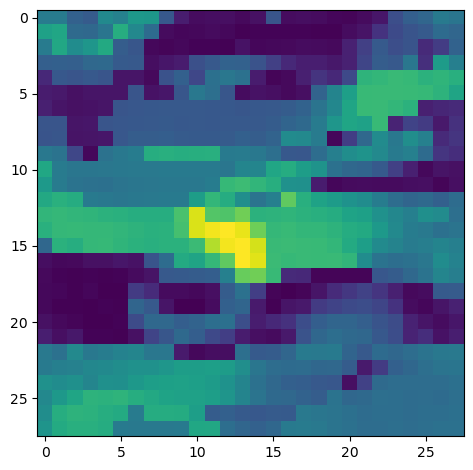

Iteration 2000 current batch loss: 8.88202953338623
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 0.9173104763031006
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.46003252267837524
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7618569731712341
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7618569731712341


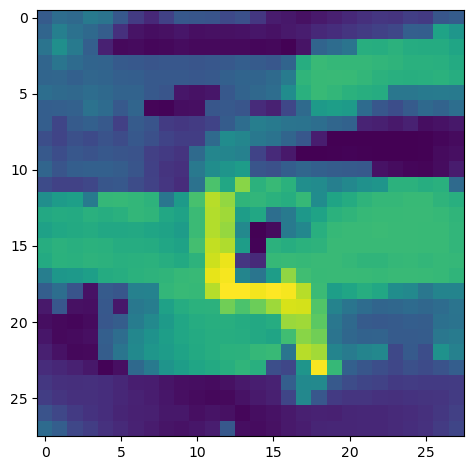

Iteration 2000 current batch loss: 6.944303512573242
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.2033180147409439
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5158076286315918
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8057828545570374
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8057828545570374


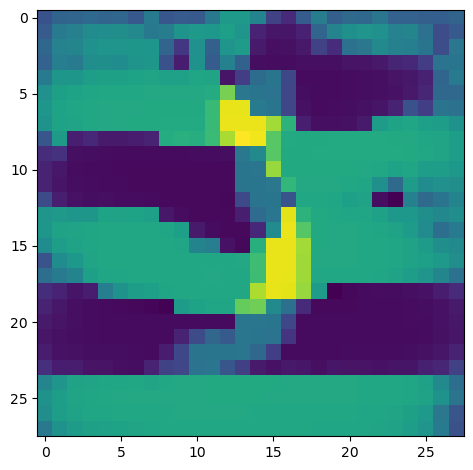

Iteration 2000 current batch loss: 8.235326766967773
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 0.20510827004909515
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.5284042954444885
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8602487444877625
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8602487444877625


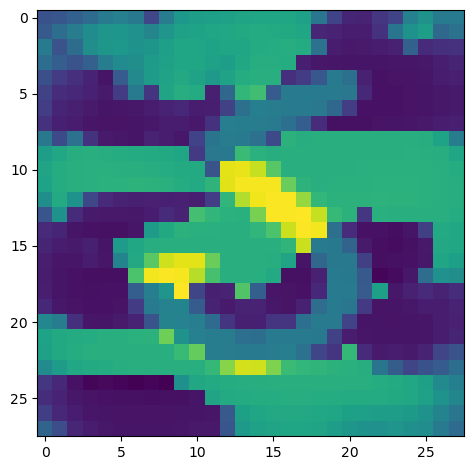

Iteration 2000 current batch loss: 11.812049865722656
tensor(5, device='cuda:0')
Iteration 4000 current batch loss: 9.809704780578613
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.47542035579681396
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.6007074117660522
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.6007074117660522


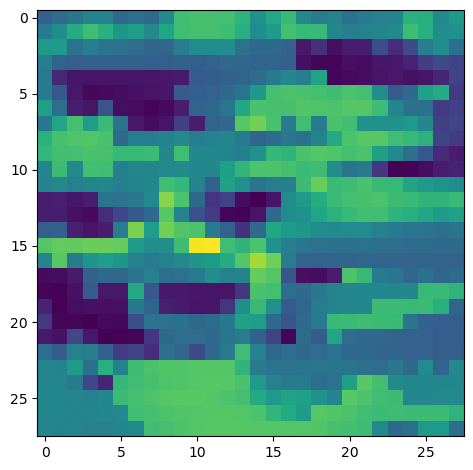

Iteration 2000 current batch loss: 10.145546913146973
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 0.7982813119888306
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.5152540802955627
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.7880865335464478
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.7880865335464478


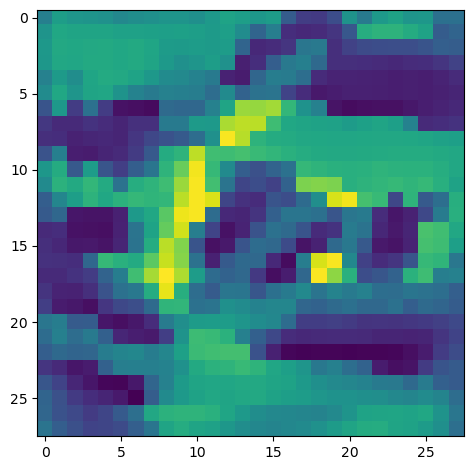

Iteration 2000 current batch loss: 9.302127838134766
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 1.4956889152526855
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.47265127301216125
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7341712713241577
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7341712713241577


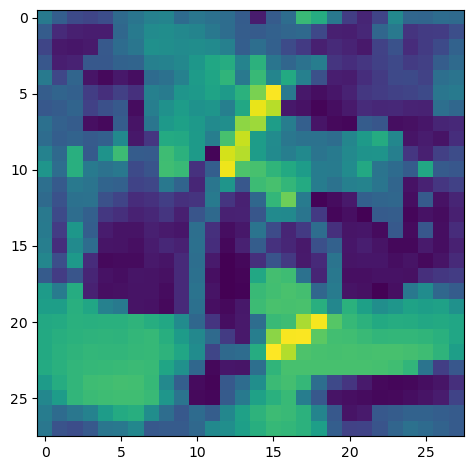

Iteration 2000 current batch loss: 8.624730110168457
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 0.20032231509685516
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.5140852332115173
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8164353966712952
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8164353966712952


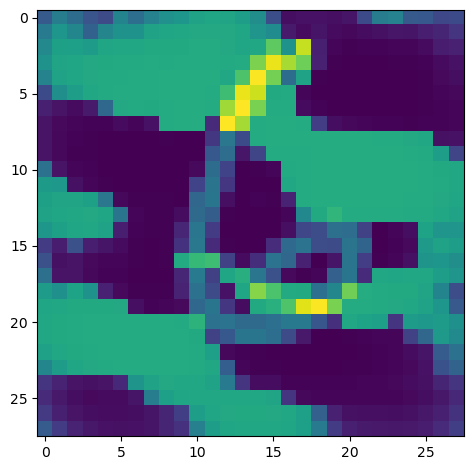

Iteration 2000 current batch loss: 13.376506805419922
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 0.22794218361377716
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.5073239803314209
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8071028590202332
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8071028590202332


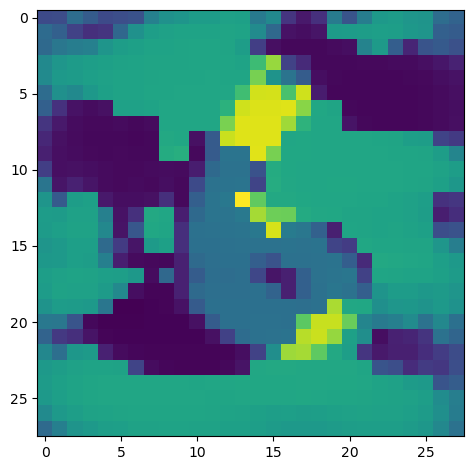

Iteration 2000 current batch loss: 7.919808864593506
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 8.216377258300781
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.42051607370376587
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6605923175811768
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6605923175811768


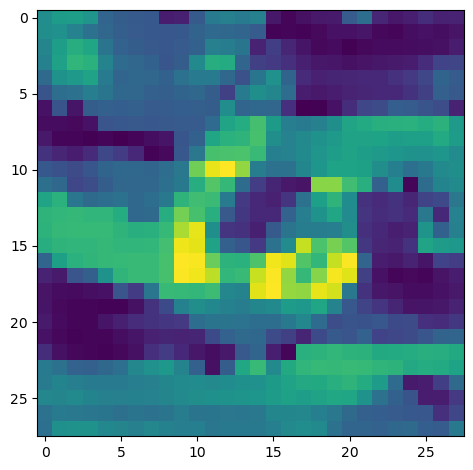

Iteration 2000 current batch loss: 9.656180381774902
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 0.20066678524017334
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.4847930371761322
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.7469398975372314
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.7469398975372314


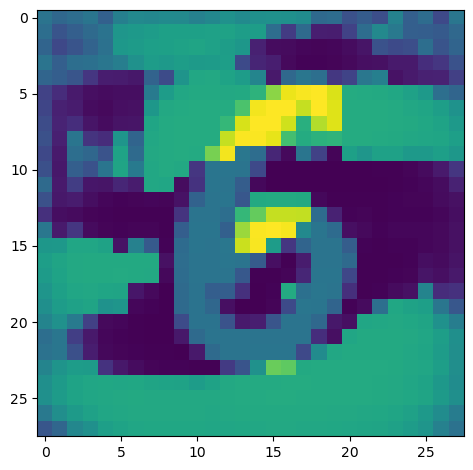

Iteration 2000 current batch loss: 15.902259826660156
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 0.5789909362792969
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5367273092269897
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8871063590049744
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8871063590049744


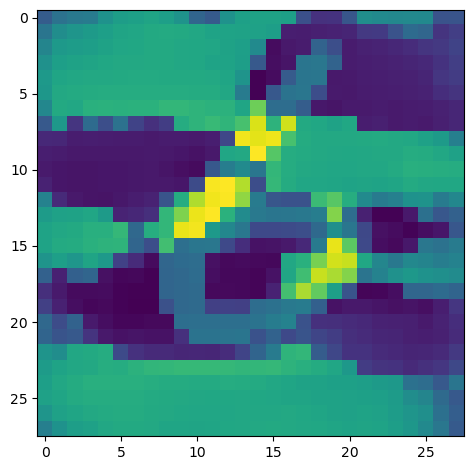

Iteration 2000 current batch loss: 11.252306938171387
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 0.20098036527633667
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.935226559638977
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8101902604103088
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8101902604103088


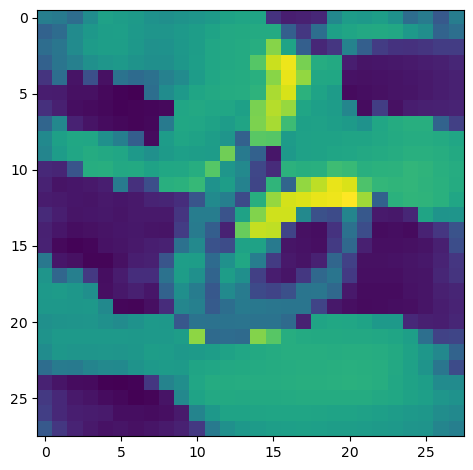

Iteration 2000 current batch loss: 15.128646850585938
tensor(6, device='cuda:0')
Iteration 4000 current batch loss: 1.597296118736267
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.46059510111808777
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7132250070571899
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7132250070571899


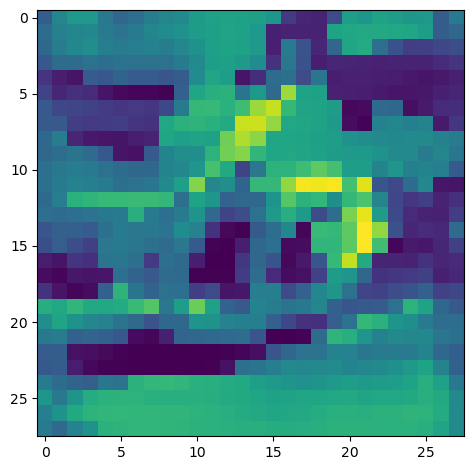

Iteration 2000 current batch loss: 14.305861473083496
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 0.20593784749507904
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.7408021092414856
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.8080456852912903
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.8080456852912903


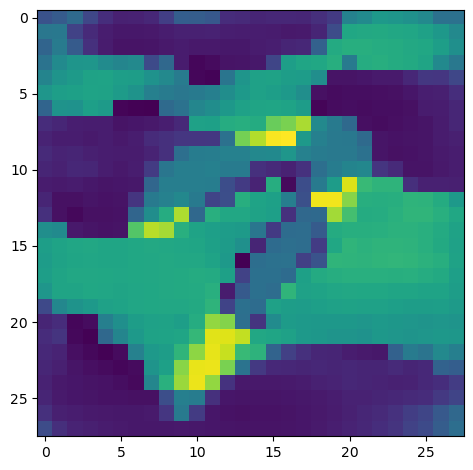

Iteration 2000 current batch loss: 6.466080665588379
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 1.9636569023132324
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.6285840272903442
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7782793641090393
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7782793641090393


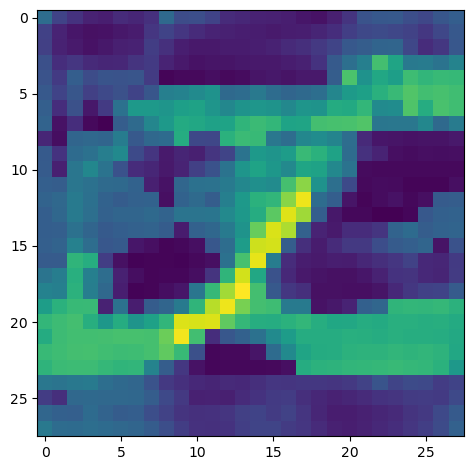

Iteration 2000 current batch loss: 5.5953755378723145
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 0.36004838347435
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.4699825942516327
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7383313179016113
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7383313179016113


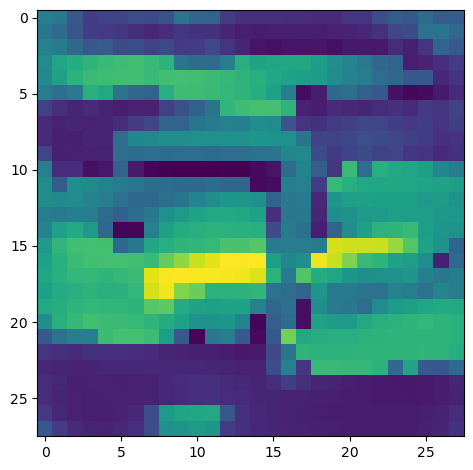

Iteration 2000 current batch loss: 6.438953876495361
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 0.20248818397521973
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.5038357377052307
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7951568961143494
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7951568961143494


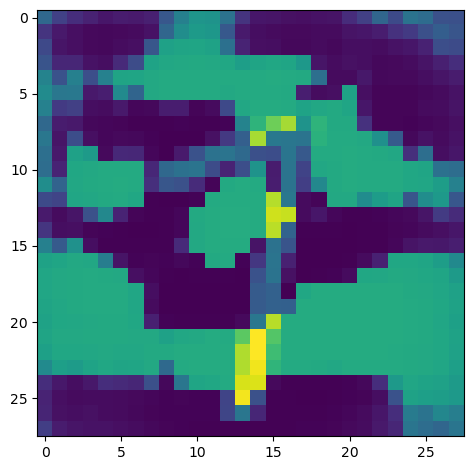

Iteration 2000 current batch loss: 17.446331024169922
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 7.22780704498291
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.3842680752277374
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6143530607223511
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.6143530607223511


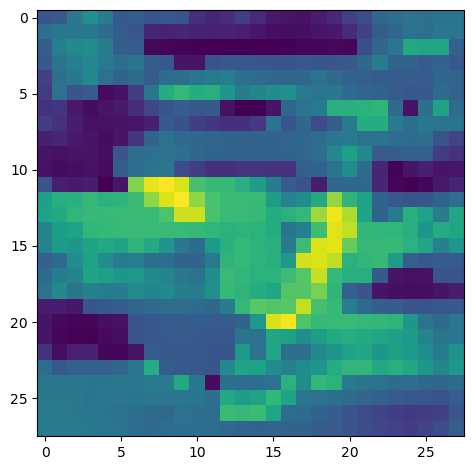

Iteration 2000 current batch loss: 9.834077835083008
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 0.20011329650878906
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.5114140510559082
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8067335486412048
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.8067335486412048


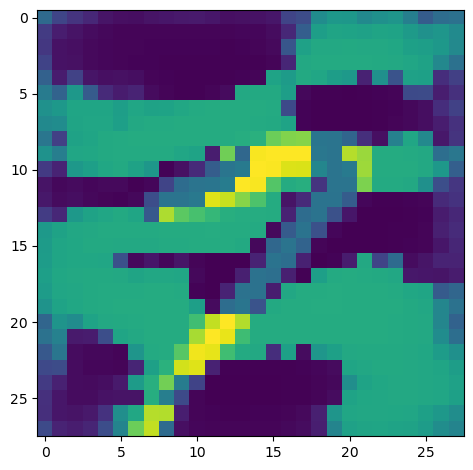

Iteration 2000 current batch loss: 23.962791442871094
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 1.506301760673523
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.5214952826499939
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.8787329792976379
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.8787329792976379


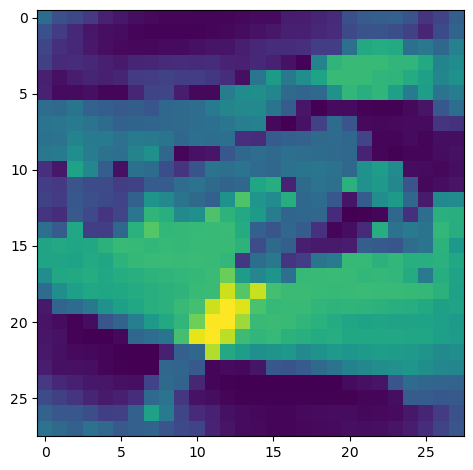

Iteration 2000 current batch loss: 14.09683609008789
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 0.22089633345603943
tensor(8, device='cuda:0')
Iteration 6000 current batch loss: 0.508345901966095
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8007072806358337
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.8007072806358337


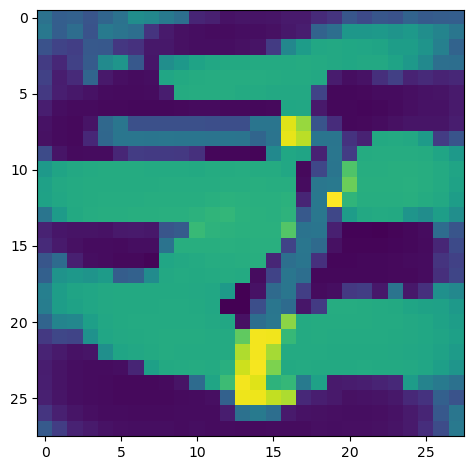

Iteration 2000 current batch loss: 7.729053974151611
tensor(7, device='cuda:0')
Iteration 4000 current batch loss: 0.3371361196041107
tensor(9, device='cuda:0')
Iteration 6000 current batch loss: 0.8112990856170654
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7503719329833984
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7503719329833984


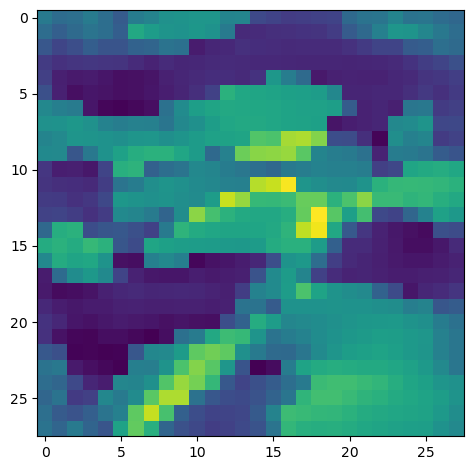

Iteration 2000 current batch loss: 9.627277374267578
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 0.24453715980052948
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.5161718130111694
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.799548327922821
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.799548327922821


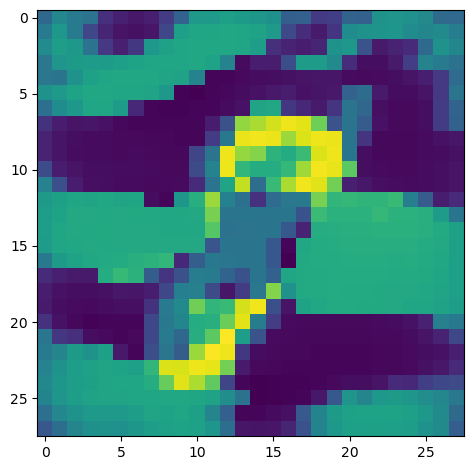

Iteration 2000 current batch loss: 11.366094589233398
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 2.3659422397613525
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.4451170563697815
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7402556538581848
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7402556538581848


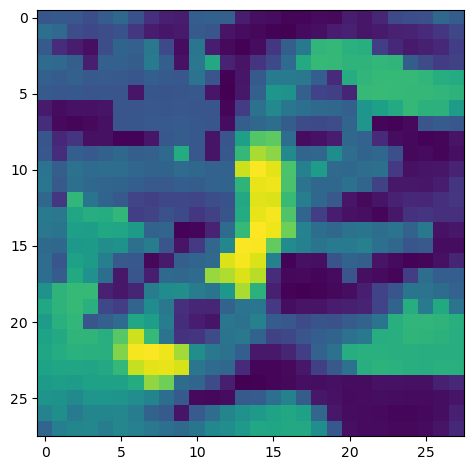

Iteration 2000 current batch loss: 10.029499053955078
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 0.20218218863010406
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.5029957890510559
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7947575449943542
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.7947575449943542


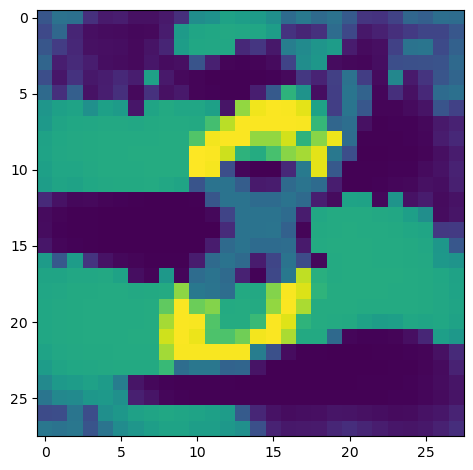

Iteration 2000 current batch loss: 7.767776012420654
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 0.20756475627422333
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.5076794028282166
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8030009269714355
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.8030009269714355


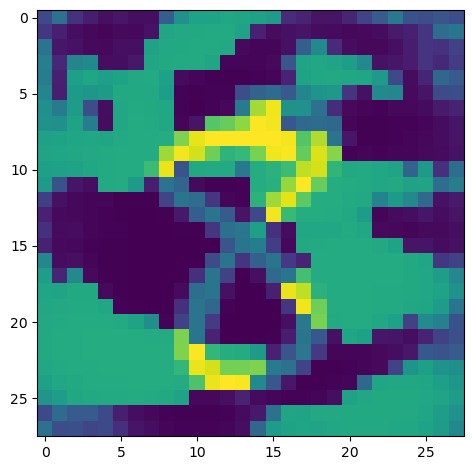

Iteration 2000 current batch loss: 10.661805152893066
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 0.5409157276153564
tensor(4, device='cuda:0')
Iteration 6000 current batch loss: 0.5093085169792175
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.8329785466194153
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.8329785466194153


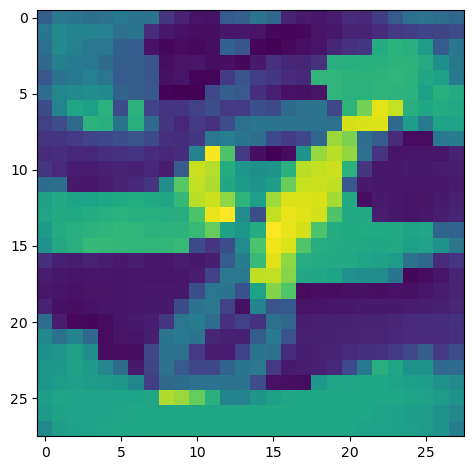

Iteration 2000 current batch loss: 10.326017379760742
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 0.20122763514518738
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.5063492655754089
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.807417094707489
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.807417094707489


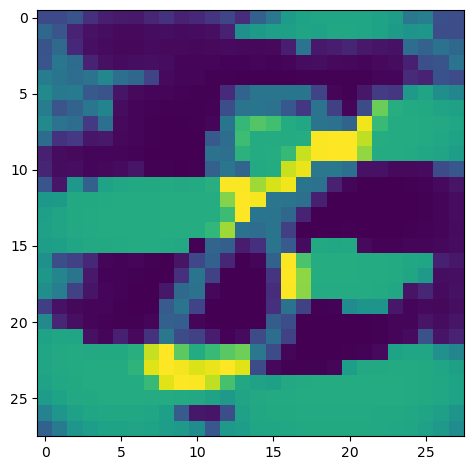

Iteration 2000 current batch loss: 19.32239532470703
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 0.20329371094703674
tensor(6, device='cuda:0')
Iteration 6000 current batch loss: 0.4906630218029022
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7654243111610413
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.7654243111610413


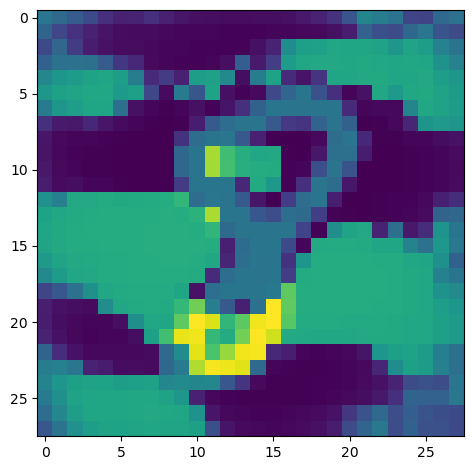

Iteration 2000 current batch loss: 13.123772621154785
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 0.2000812292098999
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5158869028091431
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8295082449913025
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.8295082449913025


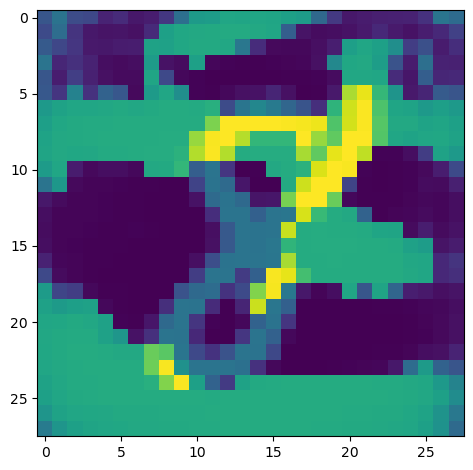

Iteration 2000 current batch loss: 10.314653396606445
tensor(8, device='cuda:0')
Iteration 4000 current batch loss: 9.679774284362793
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.4511999189853668
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7497622966766357
tensor(9, device='cuda:0')
Iteration 8000 current batch loss: 0.7497622966766357


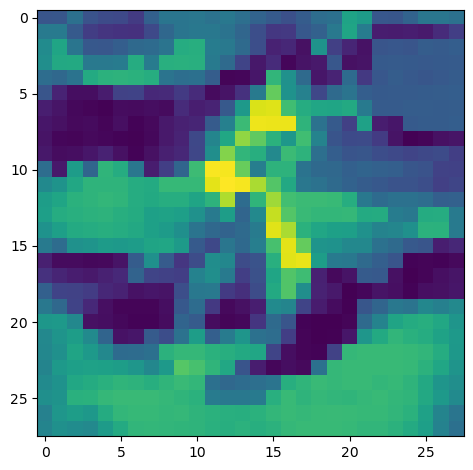

Iteration 2000 current batch loss: 15.385329246520996
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 0.38339221477508545
tensor(0, device='cuda:0')
Iteration 6000 current batch loss: 0.5265474915504456
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.844373345375061
tensor(0, device='cuda:0')
Iteration 8000 current batch loss: 0.844373345375061


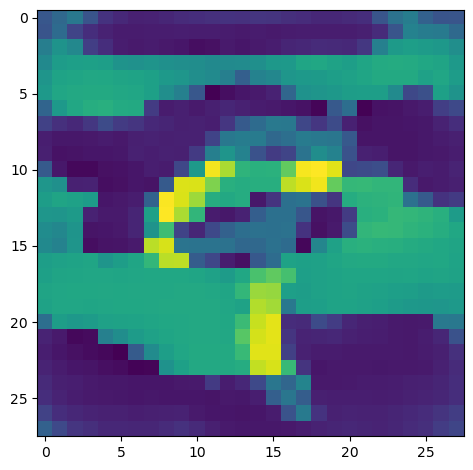

Iteration 2000 current batch loss: 10.068906784057617
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 2.868236780166626
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.9205098748207092
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7238145470619202
tensor(1, device='cuda:0')
Iteration 8000 current batch loss: 0.7238145470619202


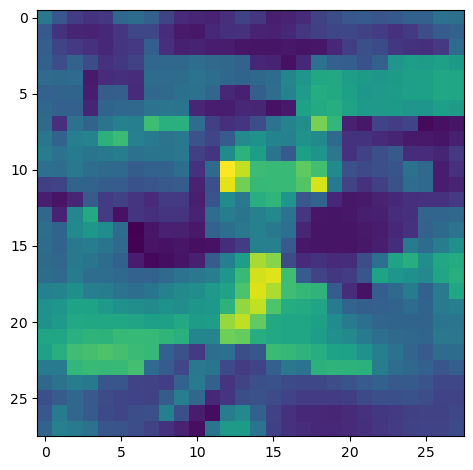

Iteration 2000 current batch loss: 7.65010404586792
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 0.20000682771205902
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.5206620097160339
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8419308066368103
tensor(2, device='cuda:0')
Iteration 8000 current batch loss: 0.8419308066368103


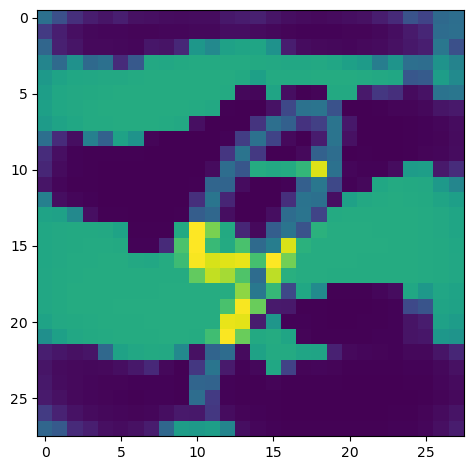

Iteration 2000 current batch loss: 9.27444076538086
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 0.22482478618621826
tensor(3, device='cuda:0')
Iteration 6000 current batch loss: 0.6432675719261169
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7782113552093506
tensor(3, device='cuda:0')
Iteration 8000 current batch loss: 0.7782113552093506


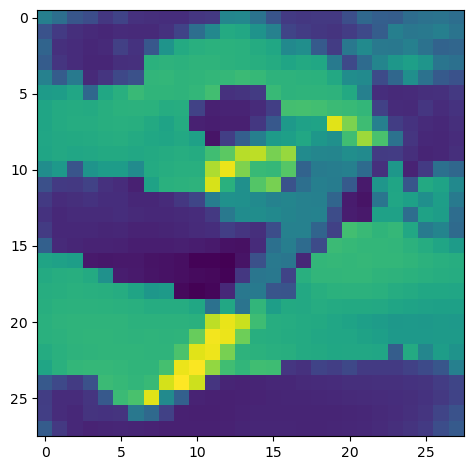

Iteration 2000 current batch loss: 9.58785629272461
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 6.941679954528809
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.38148123025894165
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.571540117263794
tensor(4, device='cuda:0')
Iteration 8000 current batch loss: 0.571540117263794


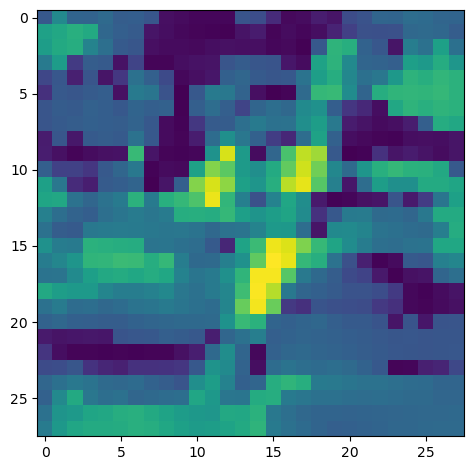

Iteration 2000 current batch loss: 11.289873123168945
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 0.20005665719509125
tensor(5, device='cuda:0')
Iteration 6000 current batch loss: 0.4922451376914978
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.766033947467804
tensor(5, device='cuda:0')
Iteration 8000 current batch loss: 0.766033947467804


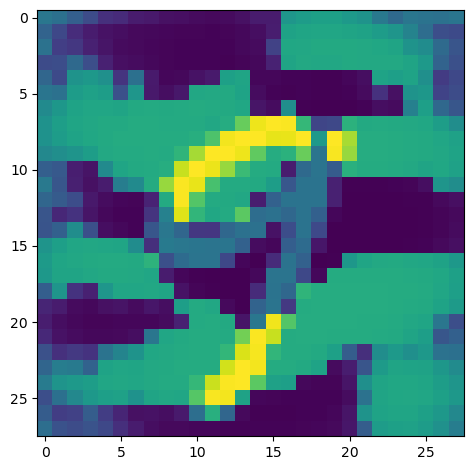

Iteration 2000 current batch loss: 10.977813720703125
tensor(3, device='cuda:0')
Iteration 4000 current batch loss: 0.2355138063430786
tensor(6, device='cuda:0')
Iteration 6000 current batch loss: 0.5291628837585449
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.843917191028595
tensor(6, device='cuda:0')
Iteration 8000 current batch loss: 0.843917191028595


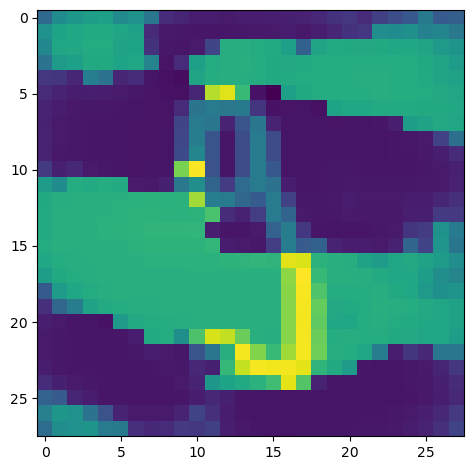

Iteration 2000 current batch loss: 4.418057441711426
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 0.2006775289773941
tensor(7, device='cuda:0')
Iteration 6000 current batch loss: 0.5068373680114746
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.7834228873252869
tensor(7, device='cuda:0')
Iteration 8000 current batch loss: 0.7834228873252869


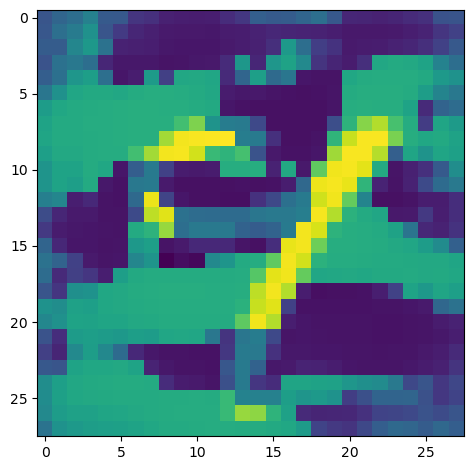

Iteration 2000 current batch loss: 10.747398376464844
tensor(9, device='cuda:0')
Iteration 4000 current batch loss: 6.159485340118408
tensor(2, device='cuda:0')
Iteration 6000 current batch loss: 0.41581180691719055
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.5889588594436646
tensor(8, device='cuda:0')
Iteration 8000 current batch loss: 0.5889588594436646


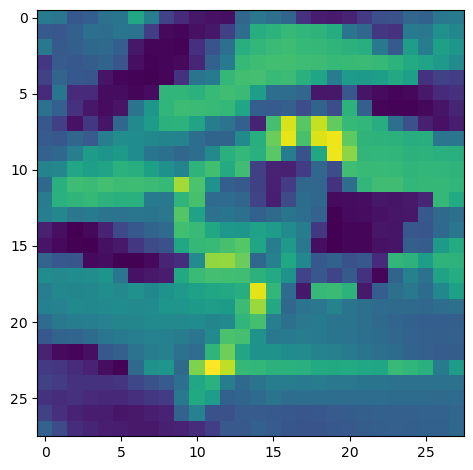

In [185]:
for i in range(90):
    plot_one_number(train_noise(net, batch_imgs[i], batch_labels[i], lambda_l2 = 0.2, info =  2000, lr = 1, max_iter = 8000))